In [1]:
import os

os.makedirs("data/00_raw", exist_ok=True)
os.makedirs("data/01_curated", exist_ok=True)
os.makedirs("reports/01_data_curation", exist_ok=True)

print("Folders created.")


Folders created.


In [2]:
!pip -q install requests tqdm pandas numpy beautifulsoup4 lxml


In [9]:
# ============================================================
# CELL 2 — Imports + Project Configuration (Machine Learning, Springer 10994)
# ============================================================
# This cell defines:
# 1) All imports used in the Data Curation stage
# 2) A single "source of truth" configuration block that controls:
#    - which journal we collect data for
#    - which years we cover (P7: 5–10 years)
#    - how many papers we aim to collect (practical cap for Colab)
#    - API endpoint + rate-limiting behavior
#    - where we save raw vs curated datasets
#
# CRITICAL (for grading / P7 compliance):
# - Primary data source MUST be an API (Semantic Scholar here).
# - CSV is created only AFTER API collection:
#   (a) caching, (b) reproducibility, (c) submission artifact.
# ============================================================

import os
import time
import json
import re
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from bs4 import BeautifulSoup

# ---------------------------
# TARGET JOURNAL (P7: "Select scientific journal with clearly defined 'Aims & Scope'")
# ---------------------------
JOURNAL_CANONICAL = "Machine Learning"  # Springer journal (Journal number: 10994)

def safe_slug(s: str) -> str:
    """Make a filesystem-safe slug for filenames (reproducibility)."""
    return "".join(ch if ch.isalnum() else "_" for ch in (s or "").strip().lower())

JOURNAL_SLUG = safe_slug(JOURNAL_CANONICAL)

# ---------------------------
# Semantic Scholar venue candidates (robust filtering)
# ---------------------------
# Venue strings can vary across databases (abbreviations, punctuation).
# We will probe candidates and automatically pick the best match.
VENUE_CANDIDATES = [
    "Machine Learning",
    "Mach. Learn.",
    "Mach Learn",
    "MLJ",
    "Machine Learning (journal)"
]

# ---------------------------
# TIME WINDOW (P7: "collect article abstracts ... over 5–10 years")
# ---------------------------
# 2016–2025 inclusive = 10 years (maximum allowed by guideline).
START_YEAR = 2016
END_YEAR = 2025
YEAR_RANGE = f"{START_YEAR}-{END_YEAR}"

# ---------------------------
# SCALE / PRACTICAL LIMITS (Colab runtime)
# ---------------------------
# TARGET_PAPERS is a cap for the curated dataset (after cleaning).
TARGET_PAPERS = 6000

# For balancing the dataset distribution across years (prevents one year dominating).
MIN_PER_YEAR = 20
MAX_MIN_RATIO = 3
MAX_PER_YEAR = 200  # Increased because journals can have many papers/year; we cap later.

# ---------------------------
# API CONFIG (P7: "Use relevant API (arXiv, Semantic Scholar, PubMed)")
# ---------------------------
# We use Semantic Scholar Academic Graph API — paper bulk search.
S2_BULK_URL = "https://api.semanticscholar.org/graph/v1/paper/search/bulk"

# ---------------------------
# AIMS & SCOPE (ground truth) — Machine Learning (Springer 10994)
# ---------------------------
SCOPE_URL = "https://link.springer.com/journal/10994/aims-and-scope"

# ---------------------------
# RATE LIMIT / ETIQUETTE
# ---------------------------
REQUEST_SLEEP_SEC = 1.1

# ---------------------------
# OPTIONAL: API KEY
# ---------------------------
# If you have an API key, set environment variable S2_API_KEY for higher rate limits.
S2_API_KEY = os.getenv("S2_API_KEY", "").strip()

# Ensure directories exist (defensive)
os.makedirs("data/00_raw", exist_ok=True)
os.makedirs("data/01_curated", exist_ok=True)
os.makedirs("reports/01_data_curation", exist_ok=True)

print("✅ Config loaded.")
print("Journal:", JOURNAL_CANONICAL)
print("Scope URL:", SCOPE_URL)
print("Years:", START_YEAR, "-", END_YEAR)
print("Target papers (cap):", TARGET_PAPERS)
print("Semantic Scholar API key provided?", bool(S2_API_KEY))


✅ Config loaded.
Journal: Machine Learning
Scope URL: https://link.springer.com/journal/10994/aims-and-scope
Years: 2016 - 2025
Target papers (cap): 6000
Semantic Scholar API key provided? False


In [10]:
# ============================================================
# CELL 3 — Retrieve Aims & Scope text (Ground Truth)
# ============================================================
# P7 requires:
#   "Select scientific journal with clearly defined 'Aims & Scope' statement
#    as ground truth for intended focus"
#
# We will:
# 1) Download the official Aims & Scope page (Springer)
# 2) Extract the main textual content
# 3) Save a snapshot to disk for reproducibility
# ============================================================

def fetch_scope_text(scope_url: str) -> str:
    """
    Fetch the Aims & Scope page HTML and extract the main textual content.

    Why this matters:
    - The scope text is our ground truth thematic reference (V_scope).
    - Saving a snapshot ensures reproducibility even if the website updates later.

    Implementation notes:
    - Springer pages may include navigation clutter.
    - We attempt to extract text from main/section/article blocks, then clean whitespace.
    """
    headers = {
        "User-Agent": "Mozilla/5.0 (compatible; P7-DataCuration/1.0)"
    }
    resp = requests.get(scope_url, headers=headers, timeout=30)
    resp.raise_for_status()

    soup = BeautifulSoup(resp.text, "lxml")

    text_candidates = []
    for selector in ["main", "article", "section"]:
        node = soup.find(selector)
        if node:
            text_candidates.append(node.get_text(separator=" ", strip=True))

    if not text_candidates:
        text_candidates.append(soup.get_text(separator=" ", strip=True))

    raw_text = max(text_candidates, key=len)
    cleaned = re.sub(r"\s+", " ", raw_text).strip()
    return cleaned


scope_text_full = fetch_scope_text(SCOPE_URL)

scope_txt_path = f"reports/01_data_curation/{JOURNAL_SLUG}_aims_scope_snapshot.txt"
with open(scope_txt_path, "w", encoding="utf-8") as f:
    f.write(scope_text_full)

print("✅ Saved Aims & Scope snapshot to:", scope_txt_path)
print("Preview (first 500 chars):")
print(scope_text_full[:500])


✅ Saved Aims & Scope snapshot to: reports/01_data_curation/machine_learning_aims_scope_snapshot.txt
Preview (first 500 chars):
Aims and scope Machine Learning is an international forum for research on computational approaches to learning. The journal publishes articles reporting substantive results on a wide range of learning methods applied to a variety of learning problems, including but not limited to: Learning Problems: Classification, regression, recognition, and prediction; Problem solving and planning; Reasoning and inference; Data mining; Web mining; Scientific discovery; Information retrieval; Natural language 


In [11]:
# ============================================================
# CELL 4 — Semantic Scholar API Helper Functions
# ============================================================
# P7 dataset requirement:
#   "Use relevant API (arXiv, Semantic Scholar, PubMed) to collect article abstracts..."
#
# We use Semantic Scholar bulk search because it can return large result sets.
# We also store raw JSONL dumps to prove:
# - the primary data source is the API (not a CSV)
# - the dataset is reproducible
# ============================================================

def s2_headers(api_key: str) -> dict:
    """Build request headers; include x-api-key if provided."""
    headers = {"User-Agent": "Mozilla/5.0 (compatible; P7-DataCuration/1.0)"}
    if api_key:
        headers["x-api-key"] = api_key
    return headers


def s2_get(url: str, params: dict, api_key: str, max_retries: int = 5) -> dict:
    """
    Robust GET request wrapper for Semantic Scholar API.

    Retries on transient conditions:
    - 429 (rate limit)
    - 5xx server errors
    Uses exponential backoff to be polite and stable.
    """
    headers = s2_headers(api_key)
    backoff = 1.5

    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.get(url, params=params, headers=headers, timeout=60)

            if resp.status_code == 200:
                return resp.json()

            if resp.status_code in (429, 500, 502, 503, 504):
                print(f"⚠️ HTTP {resp.status_code} (attempt {attempt}/{max_retries}). Backing off...")
                time.sleep(REQUEST_SLEEP_SEC * (backoff ** attempt))
                continue

            print("❌ Non-retriable error:", resp.status_code, resp.text[:300])
            resp.raise_for_status()

        except Exception as e:
            print(f"⚠️ Exception on attempt {attempt}/{max_retries}: {repr(e)}")
            time.sleep(REQUEST_SLEEP_SEC * (backoff ** attempt))

    raise RuntimeError("Semantic Scholar API request failed after retries.")


def normalize_paper_record(p: dict) -> dict:
    """
    Normalize a Semantic Scholar paper JSON into a flat row.

    Important:
    - For journals, venue information may appear in:
        p["publicationVenue"]["name"]
      while legacy p["venue"] can be empty.
    """
    authors = p.get("authors") or []
    author_names = [a.get("name", "") for a in authors if isinstance(a, dict)]

    external = p.get("externalIds") or {}
    pub_venue = p.get("publicationVenue") or {}

    venue_name = ""
    if isinstance(pub_venue, dict):
        venue_name = pub_venue.get("name", "") or ""
    if not venue_name:
        venue_name = p.get("venue", "") or ""

    pub_types = p.get("publicationTypes") or []

    return {
        "paperId": p.get("paperId", "") or "",
        "title": p.get("title", "") or "",
        "abstract": p.get("abstract", "") or "",
        "year": p.get("year", None),
        "venue_name": venue_name,
        "venue_raw": p.get("venue", "") or "",
        "publicationVenue_raw": json.dumps(pub_venue) if pub_venue else "",
        "publicationTypes": ";".join(pub_types) if isinstance(pub_types, list) else str(pub_types),
        "authors": "; ".join([x for x in author_names if x]),
        "url": p.get("url", "") or "",
        "doi": external.get("DOI", "") if isinstance(external, dict) else ""
    }


def bulk_search_collect(
    query: str,
    venue: str,
    year_range: str,
    fields: str,
    api_key: str,
    max_items: int,
    raw_jsonl_path: str
) -> list:
    """
    Collect papers using /paper/search/bulk with token pagination.

    Why bulk search:
    - Suitable for collecting many records (better for dataset creation).

    What we store:
    - raw_jsonl_path receives one JSON object per line (audit trail).

    Returns:
    - a list of normalized rows (dicts) ready for DataFrame.
    """
    rows = []
    token = None

    with open(raw_jsonl_path, "w", encoding="utf-8") as raw_file:
        while len(rows) < max_items:
            params = {
                "query": query,
                "fields": fields,
                "year": year_range,   # restrict by publication year range
                "venue": venue        # restrict by journal/venue name
            }
            if token:
                params["token"] = token

            response = s2_get(S2_BULK_URL, params=params, api_key=api_key)

            data = response.get("data", [])
            token = response.get("token", None)

            if not data:
                break

            for p in data:
                raw_file.write(json.dumps(p) + "\n")
                rows.append(normalize_paper_record(p))
                if len(rows) >= max_items:
                    break

            if not token:
                break

            time.sleep(REQUEST_SLEEP_SEC)

    return rows


print("✅ Semantic Scholar helper functions loaded.")


✅ Semantic Scholar helper functions loaded.


In [13]:
# ============================================================
# CELL 5 — Collect canonical Machine Learning (Springer 10994) DOIs via Crossref API (FIXED)
# ============================================================
# FIX SUMMARY:
# - Crossref /works cursor pagination supports:
#     cursor=*   (first request)
#     rows=N
#   and the response includes:
#     message["next-cursor"]
# - There is NO "cursor-max" parameter on this route (it triggers HTTP 400).
#
# References (Crossref docs):
# - Use cursor=* to start, then repeatedly use next-cursor. Stop when returned items < rows. :contentReference[oaicite:1]{index=1}
# ============================================================

import time
import json
import requests
import pandas as pd
from tqdm import tqdm

# ---------------------------
# Journal identifiers (Machine Learning, Springer 10994)
# ---------------------------
JOURNAL_ISSN_PRINT = "0885-6125"
JOURNAL_ISSN_E     = "1573-0565"

CROSSREF_URL = "https://api.crossref.org/works"

# Polite etiquette: identify your script (recommended by Crossref)
CROSSREF_MAILTO = ""  # optional: "yourname@unimi.it"
CROSSREF_UA = f"P7-ThematicAlignment/1.0 (mailto:{CROSSREF_MAILTO or 'not_provided'})"

ROWS_PER_PAGE = 200     # safe chunk size for Colab
MAX_ITEMS = 20000       # safety cap to avoid infinite loops

FROM_DATE  = f"{START_YEAR}-01-01"
UNTIL_DATE = f"{END_YEAR}-12-31"

def crossref_get(params, max_retries=6):
    """
    Robust request helper for Crossref REST API.
    Retries transient errors (429 / 5xx) with exponential backoff.
    """
    headers = {"User-Agent": CROSSREF_UA}
    backoff = 1.6

    for attempt in range(1, max_retries + 1):
        r = requests.get(CROSSREF_URL, params=params, headers=headers, timeout=60)

        if r.status_code == 200:
            return r.json()

        if r.status_code in (429, 500, 502, 503, 504):
            sleep_s = (backoff ** attempt)
            print(f"⚠️ Crossref HTTP {r.status_code}. Retry {attempt}/{max_retries} in {sleep_s:.1f}s")
            time.sleep(sleep_s)
            continue

        # Non-retriable error
        print("❌ Crossref non-retriable:", r.status_code, r.text[:250])
        r.raise_for_status()

    raise RuntimeError("Crossref failed after retries.")


def pick_year_from_item(it: dict):
    """
    Extract publication year from Crossref item.
    We try issued -> published-online -> published-print in that order.
    """
    def pick_year(obj):
        try:
            parts = obj.get("date-parts", [])
            if parts and parts[0] and isinstance(parts[0][0], int):
                return parts[0][0]
        except Exception:
            pass
        return None

    return (
        pick_year(it.get("issued", {}))
        or pick_year(it.get("published-online", {}))
        or pick_year(it.get("published-print", {}))
    )


def harvest_crossref_dois(issn: str) -> pd.DataFrame:
    """
    Harvest DOIs for a journal using ISSN + date range filters.

    Cursor-based pagination workflow:
    1) First request: cursor=*
    2) Read next-cursor from response
    3) Repeat with cursor=<next-cursor>
    4) Stop when returned items < ROWS_PER_PAGE  (Crossref returns next-cursor even on last page) :contentReference[oaicite:2]{index=2}
    """
    cursor = "*"
    out = []
    fetched = 0

    pbar = tqdm(total=MAX_ITEMS, desc=f"Crossref harvest (ISSN={issn})")

    while fetched < MAX_ITEMS:
        params = {
            "filter": f"issn:{issn},from-pub-date:{FROM_DATE},until-pub-date:{UNTIL_DATE},type:journal-article",
            "rows": ROWS_PER_PAGE,
            "cursor": cursor,
            "select": "DOI,title,container-title,issued,published-online,published-print,type"
        }

        data = crossref_get(params)
        message = data.get("message", {})
        items = message.get("items", [])
        next_cursor = message.get("next-cursor", None)

        if not items:
            break

        for it in items:
            doi = (it.get("DOI") or "").strip()
            if not doi:
                continue

            year = pick_year_from_item(it)
            title = (it.get("title") or [""])[0]
            container = (it.get("container-title") or [""])[0]

            out.append({
                "doi": doi.lower(),
                "title_crossref": title,
                "container_title_crossref": container,
                "year_crossref": year,
                "type_crossref": it.get("type", "")
            })

        fetched += len(items)
        pbar.update(len(items))

        # Stop condition recommended by Crossref:
        # last page reached when returned items < requested rows. :contentReference[oaicite:3]{index=3}
        if len(items) < ROWS_PER_PAGE:
            break

        if not next_cursor:
            break

        cursor = next_cursor
        time.sleep(0.2)  # polite delay

    pbar.close()
    return pd.DataFrame(out)


# 1) Harvest using BOTH ISSNs, union + dedup
df_doi_print = harvest_crossref_dois(JOURNAL_ISSN_PRINT)
df_doi_e     = harvest_crossref_dois(JOURNAL_ISSN_E)

df_dois = pd.concat([df_doi_print, df_doi_e], ignore_index=True)
df_dois = df_dois.drop_duplicates(subset=["doi"]).reset_index(drop=True)

# 2) Defensive year filter
df_dois["year_crossref"] = pd.to_numeric(df_dois["year_crossref"], errors="coerce")
df_dois = df_dois[(df_dois["year_crossref"] >= START_YEAR) & (df_dois["year_crossref"] <= END_YEAR)].copy()

# 3) Save raw snapshot (audit + reproducibility)
raw_crossref_path = f"data/00_raw/{JOURNAL_SLUG}_crossref_dois_{START_YEAR}_{END_YEAR}.csv"
df_dois.to_csv(raw_crossref_path, index=False)

print("✅ Crossref DOI harvest completed.")
print("Total unique DOIs:", len(df_dois))
print("Saved DOI snapshot:", raw_crossref_path)

display(df_dois.head(5))




Crossref harvest (ISSN=0885-6125):   0%|          | 0/20000 [00:00<?, ?it/s]

Crossref harvest (ISSN=0885-6125):   1%|          | 200/20000 [00:01<01:51, 177.25it/s]

Crossref harvest (ISSN=0885-6125):   2%|▏         | 400/20000 [00:02<01:54, 171.91it/s]

Crossref harvest (ISSN=0885-6125):   3%|▎         | 600/20000 [00:03<01:54, 170.02it/s]

Crossref harvest (ISSN=0885-6125):   4%|▍         | 800/20000 [00:04<01:53, 169.34it/s]

Crossref harvest (ISSN=0885-6125):   5%|▌         | 1000/20000 [00:05<01:53, 167.65it/s]

Crossref harvest (ISSN=0885-6125):   6%|▌         | 1200/20000 [00:07<01:53, 165.82it/s]

Crossref harvest (ISSN=0885-6125):   7%|▋         | 1385/20000 [00:08<01:54, 163.29it/s]


Crossref harvest (ISSN=1573-0565):   0%|          | 0/20000 [00:00<?, ?it/s]

Crossref harvest (ISSN=1573-0565):   1%|          | 200/20000 [00:00<01:36, 205.46it/s]

Crossref harvest (ISSN=1573-0565):   2%|▏         | 400/20000 [00:02<01:49, 179.77it/s]

Crossref harvest (ISSN=1573-0565):   

✅ Crossref DOI harvest completed.
Total unique DOIs: 1385
Saved DOI snapshot: data/00_raw/machine_learning_crossref_dois_2016_2025.csv


,doi,title_crossref,container_title_crossref,year_crossref,type_crossref
0,10.1007/s10994-018-5698-0,Output Fisher embedding regression,Machine Learning,2018,journal-article
1,10.1007/s10994-021-06029-z,Multimodal deep learning for cetacean distribu...,Machine Learning,2021,journal-article
2,10.1007/s10994-019-05865-4,High-dimensional model recovery from random sk...,Machine Learning,2020,journal-article
3,10.1007/s10994-016-5571-y,On the need for structure modelling in sequenc...,Machine Learning,2016,journal-article
4,10.1007/s10994-020-05876-6,Editorial: Machine learning for safety–critica...,Machine Learning,2020,journal-article


In [15]:
# ============================================================
# CELL 6 — Enrich DOIs with Semantic Scholar (RATE-LIMIT SAFE + RESUMABLE)
# ============================================================
# Why this version:
# - Without an API key, Semantic Scholar rate limits are strict (HTTP 429).
# - We add:
#   (1) slower base delay
#   (2) stronger exponential backoff on 429
#   (3) resumability via a checkpoint CSV
#   (4) caching of already processed DOIs
# ============================================================

import os
import json
import time
import random
import requests
import pandas as pd
from tqdm import tqdm

S2_PAPER_URL = "https://api.semanticscholar.org/graph/v1/paper/"
S2_FIELDS = "paperId,title,abstract,year,authors,publicationVenue,externalIds,url,publicationTypes"

CHECKPOINT_PATH = f"data/00_raw/{JOURNAL_SLUG}_s2_enrichment_checkpoint_{START_YEAR}_{END_YEAR}.csv"
RAW_JSONL_PATH = f"data/00_raw/{JOURNAL_SLUG}_s2_by_doi_{START_YEAR}_{END_YEAR}.jsonl"

# --- Base request pacing (NO API KEY) ---
BASE_SLEEP = 0.45   # increase this if you still see 429 often
JITTER = 0.20       # random small delay to avoid burst patterns

def s2_headers(api_key: str) -> dict:
    headers = {"User-Agent": "P7-ThematicAlignment/1.0"}
    if api_key:
        headers["x-api-key"] = api_key
    return headers

def s2_fetch_by_doi_safe(doi: str, api_key: str, max_retries: int = 8):
    """
    Fetch paper by DOI with stronger 429 handling.
    Returns:
      - dict JSON on success
      - None if 404 (not found)
    """
    url = S2_PAPER_URL + "DOI:" + doi
    params = {"fields": S2_FIELDS}
    headers = s2_headers(api_key)

    for attempt in range(1, max_retries + 1):
        r = requests.get(url, params=params, headers=headers, timeout=60)

        if r.status_code == 200:
            return r.json()

        if r.status_code == 404:
            return None

        if r.status_code == 429:
            # Stronger backoff for rate limiting
            # Add jitter so we don't sync with server windows.
            sleep_s = (2.0 ** attempt) + random.uniform(0, 1.0)
            print(f"⚠️ S2 HTTP 429. Backing off {sleep_s:.1f}s (attempt {attempt}/{max_retries})")
            time.sleep(sleep_s)
            continue

        if r.status_code in (500, 502, 503, 504):
            sleep_s = (1.7 ** attempt) + random.uniform(0, 0.8)
            print(f"⚠️ S2 HTTP {r.status_code}. Retry in {sleep_s:.1f}s (attempt {attempt}/{max_retries})")
            time.sleep(sleep_s)
            continue

        print("❌ S2 non-retriable:", r.status_code, r.text[:200])
        r.raise_for_status()

    # If we exhausted retries, return a special marker (so we can retry later if needed)
    return {"_error": "max_retries_exceeded", "_doi": doi}

def normalize_s2(p: dict, doi_hint: str) -> dict:
    authors = p.get("authors") or []
    author_names = [a.get("name","") for a in authors if isinstance(a, dict)]

    pub_venue = p.get("publicationVenue") or {}
    venue_name = pub_venue.get("name","") if isinstance(pub_venue, dict) else ""

    external = p.get("externalIds") or {}
    doi = external.get("DOI","") if isinstance(external, dict) else ""
    doi = (doi or doi_hint).lower()

    return {
        "doi": doi,
        "paperId": p.get("paperId","") or "",
        "title": p.get("title","") or "",
        "abstract": p.get("abstract","") or "",
        "year": p.get("year", None),
        "venue_name": venue_name,
        "publicationTypes": ";".join(p.get("publicationTypes") or []),
        "authors": "; ".join([x for x in author_names if x]),
        "url": p.get("url","") or ""
    }

# ---------------------------
# Resume logic: load checkpoint if exists
# ---------------------------
if os.path.exists(CHECKPOINT_PATH):
    df_ckpt = pd.read_csv(CHECKPOINT_PATH)
    done_dois = set(df_ckpt["doi"].astype(str).str.lower().tolist())
    rows = df_ckpt.to_dict("records")
    print(f"✅ Loaded checkpoint: {len(done_dois)} DOIs already processed.")
else:
    done_dois = set()
    rows = []
    print("✅ No checkpoint found. Starting fresh.")

dois_all = df_dois["doi"].astype(str).str.lower().tolist()
dois_todo = [d for d in dois_all if d not in done_dois]

print(f"Total DOIs: {len(dois_all)} | Remaining: {len(dois_todo)}")

# ---------------------------
# Main enrichment loop (resumable)
# ---------------------------
with open(RAW_JSONL_PATH, "a", encoding="utf-8") as f:
    for doi in tqdm(dois_todo, desc="S2 enrich by DOI (safe)"):
        time.sleep(BASE_SLEEP + random.uniform(0, JITTER))

        p = s2_fetch_by_doi_safe(doi, api_key=S2_API_KEY)

        if p is None:
            # not found in S2
            rows.append({"doi": doi, "paperId": "", "title": "", "abstract": "", "year": None,
                         "venue_name": "", "publicationTypes": "", "authors": "", "url": "", "_status": "not_found"})
        elif isinstance(p, dict) and p.get("_error"):
            # retried too many times; mark and continue
            rows.append({"doi": doi, "paperId": "", "title": "", "abstract": "", "year": None,
                         "venue_name": "", "publicationTypes": "", "authors": "", "url": "", "_status": "retry_failed"})
        else:
            f.write(json.dumps(p) + "\n")
            row = normalize_s2(p, doi_hint=doi)
            row["_status"] = "ok"
            rows.append(row)

        # Save checkpoint every 25 items (so we can always resume)
        if len(rows) % 25 == 0:
            pd.DataFrame(rows).to_csv(CHECKPOINT_PATH, index=False)

# Final save
df_s2 = pd.DataFrame(rows)
df_s2.to_csv(CHECKPOINT_PATH, index=False)

print("\n✅ Enrichment finished (or checkpointed).")
print("Checkpoint saved:", CHECKPOINT_PATH)

# Quick status breakdown
print(df_s2["_status"].value_counts(dropna=False))


✅ No checkpoint found. Starting fresh.
Total DOIs: 1385 | Remaining: 1385




S2 enrich by DOI (safe):   0%|          | 0/1385 [00:00<?, ?it/s]

S2 enrich by DOI (safe):   0%|          | 1/1385 [00:00<19:09,  1.20it/s]

S2 enrich by DOI (safe):   0%|          | 2/1385 [00:01<18:29,  1.25it/s]

S2 enrich by DOI (safe):   0%|          | 3/1385 [00:02<21:44,  1.06it/s]

S2 enrich by DOI (safe):   0%|          | 4/1385 [00:03<20:49,  1.11it/s]

S2 enrich by DOI (safe):   0%|          | 5/1385 [00:04<20:28,  1.12it/s]

S2 enrich by DOI (safe):   0%|          | 6/1385 [00:05<20:11,  1.14it/s]

S2 enrich by DOI (safe):   1%|          | 7/1385 [00:06<19:23,  1.18it/s]

S2 enrich by DOI (safe):   1%|          | 8/1385 [00:06<19:08,  1.20it/s]

S2 enrich by DOI (safe):   1%|          | 9/1385 [00:07<18:59,  1.21it/s]

S2 enrich by DOI (safe):   1%|          | 10/1385 [00:08<18:44,  1.22it/s]

S2 enrich by DOI (safe):   1%|          | 11/1385 [00:09<18:52,  1.21it/s]

S2 enrich by DOI (safe):   1%|          | 12/1385 [00:10<18:59,  1.21it/s]

S2 enrich by DOI (safe):   1

⚠️ S2 HTTP 429. Backing off 2.1s (attempt 1/8)
⚠️ S2 HTTP 429. Backing off 4.3s (attempt 2/8)
⚠️ S2 HTTP 429. Backing off 8.2s (attempt 3/8)
⚠️ S2 HTTP 429. Backing off 16.4s (attempt 4/8)
⚠️ S2 HTTP 429. Backing off 32.5s (attempt 5/8)
⚠️ S2 HTTP 429. Backing off 64.4s (attempt 6/8)
⚠️ S2 HTTP 429. Backing off 128.6s (attempt 7/8)




S2 enrich by DOI (safe):  16%|█▌        | 215/1385 [07:25<25:31:35, 78.54s/it]

S2 enrich by DOI (safe):  16%|█▌        | 216/1385 [07:26<17:55:43, 55.21s/it]

S2 enrich by DOI (safe):  16%|█▌        | 217/1385 [07:26<12:36:36, 38.87s/it]

S2 enrich by DOI (safe):  16%|█▌        | 218/1385 [07:27<8:54:12, 27.47s/it] 

S2 enrich by DOI (safe):  16%|█▌        | 219/1385 [07:28<6:19:30, 19.53s/it]

S2 enrich by DOI (safe):  16%|█▌        | 220/1385 [07:29<4:30:08, 13.91s/it]

S2 enrich by DOI (safe):  16%|█▌        | 221/1385 [07:30<3:13:31,  9.98s/it]

S2 enrich by DOI (safe):  16%|█▌        | 222/1385 [07:31<2:21:57,  7.32s/it]

S2 enrich by DOI (safe):  16%|█▌        | 223/1385 [07:32<1:43:38,  5.35s/it]

S2 enrich by DOI (safe):  16%|█▌        | 224/1385 [07:32<1:16:55,  3.98s/it]

S2 enrich by DOI (safe):  16%|█▌        | 225/1385 [07:33<58:18,  3.02s/it]  

S2 enrich by DOI (safe):  16%|█▋        | 226/1385 [07:34<45:29,  2.36s/it]

S2 enrich by DOI (safe):  16%|█▋        | 227/13

⚠️ S2 HTTP 429. Backing off 2.1s (attempt 1/8)
⚠️ S2 HTTP 429. Backing off 4.4s (attempt 2/8)
⚠️ S2 HTTP 429. Backing off 8.1s (attempt 3/8)
⚠️ S2 HTTP 429. Backing off 16.8s (attempt 4/8)
⚠️ S2 HTTP 429. Backing off 32.4s (attempt 5/8)
⚠️ S2 HTTP 429. Backing off 64.5s (attempt 6/8)
⚠️ S2 HTTP 429. Backing off 128.4s (attempt 7/8)




S2 enrich by DOI (safe):  32%|███▏      | 441/1385 [14:56<20:37:47, 78.67s/it]

S2 enrich by DOI (safe):  32%|███▏      | 442/1385 [14:57<14:29:13, 55.31s/it]

S2 enrich by DOI (safe):  32%|███▏      | 443/1385 [14:57<10:11:21, 38.94s/it]

S2 enrich by DOI (safe):  32%|███▏      | 444/1385 [14:58<7:12:58, 27.61s/it] 

S2 enrich by DOI (safe):  32%|███▏      | 445/1385 [14:59<5:06:40, 19.58s/it]

S2 enrich by DOI (safe):  32%|███▏      | 446/1385 [15:00<3:39:29, 14.03s/it]

S2 enrich by DOI (safe):  32%|███▏      | 447/1385 [15:01<2:38:41, 10.15s/it]

S2 enrich by DOI (safe):  32%|███▏      | 448/1385 [15:02<1:54:53,  7.36s/it]

S2 enrich by DOI (safe):  32%|███▏      | 449/1385 [15:03<1:23:54,  5.38s/it]

S2 enrich by DOI (safe):  32%|███▏      | 450/1385 [15:04<1:02:25,  4.01s/it]

S2 enrich by DOI (safe):  33%|███▎      | 451/1385 [15:05<46:59,  3.02s/it]  

S2 enrich by DOI (safe):  33%|███▎      | 452/1385 [15:05<36:54,  2.37s/it]

S2 enrich by DOI (safe):  33%|███▎      | 453/13

⚠️ S2 HTTP 429. Backing off 2.6s (attempt 1/8)
⚠️ S2 HTTP 429. Backing off 4.7s (attempt 2/8)
⚠️ S2 HTTP 429. Backing off 8.6s (attempt 3/8)
⚠️ S2 HTTP 429. Backing off 16.3s (attempt 4/8)
⚠️ S2 HTTP 429. Backing off 32.8s (attempt 5/8)
⚠️ S2 HTTP 429. Backing off 64.9s (attempt 6/8)
⚠️ S2 HTTP 429. Backing off 128.6s (attempt 7/8)




S2 enrich by DOI (safe):  48%|████▊     | 665/1385 [22:26<15:46:06, 78.84s/it]

S2 enrich by DOI (safe):  48%|████▊     | 666/1385 [22:27<11:04:45, 55.47s/it]

S2 enrich by DOI (safe):  48%|████▊     | 667/1385 [22:28<7:47:17, 39.05s/it] 

S2 enrich by DOI (safe):  48%|████▊     | 668/1385 [22:29<5:29:33, 27.58s/it]

S2 enrich by DOI (safe):  48%|████▊     | 669/1385 [22:30<3:53:25, 19.56s/it]

S2 enrich by DOI (safe):  48%|████▊     | 670/1385 [22:30<2:45:57, 13.93s/it]

S2 enrich by DOI (safe):  48%|████▊     | 671/1385 [22:31<1:59:06, 10.01s/it]

S2 enrich by DOI (safe):  49%|████▊     | 672/1385 [22:32<1:25:49,  7.22s/it]

S2 enrich by DOI (safe):  49%|████▊     | 673/1385 [22:33<1:02:42,  5.28s/it]

S2 enrich by DOI (safe):  49%|████▊     | 674/1385 [22:33<46:23,  3.92s/it]  

S2 enrich by DOI (safe):  49%|████▊     | 675/1385 [22:34<35:18,  2.98s/it]

S2 enrich by DOI (safe):  49%|████▉     | 676/1385 [22:35<27:11,  2.30s/it]

S2 enrich by DOI (safe):  49%|████▉     | 677/1385 

⚠️ S2 HTTP 429. Backing off 2.9s (attempt 1/8)
⚠️ S2 HTTP 429. Backing off 4.7s (attempt 2/8)
⚠️ S2 HTTP 429. Backing off 8.7s (attempt 3/8)
⚠️ S2 HTTP 429. Backing off 16.5s (attempt 4/8)
⚠️ S2 HTTP 429. Backing off 33.0s (attempt 5/8)
⚠️ S2 HTTP 429. Backing off 64.6s (attempt 6/8)
⚠️ S2 HTTP 429. Backing off 128.0s (attempt 7/8)




S2 enrich by DOI (safe):  64%|██████▎   | 882/1385 [29:57<11:03:20, 79.13s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 883/1385 [29:58<7:45:13, 55.60s/it] 

S2 enrich by DOI (safe):  64%|██████▍   | 884/1385 [29:59<5:26:47, 39.14s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 885/1385 [30:00<3:50:19, 27.64s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 886/1385 [30:00<2:42:42, 19.56s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 887/1385 [30:01<1:56:27, 14.03s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 888/1385 [30:02<1:23:09, 10.04s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 889/1385 [30:03<1:00:15,  7.29s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 890/1385 [30:04<44:48,  5.43s/it]  

S2 enrich by DOI (safe):  64%|██████▍   | 891/1385 [30:05<34:06,  4.14s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 892/1385 [30:06<26:20,  3.21s/it]

S2 enrich by DOI (safe):  64%|██████▍   | 893/1385 [30:07<20:24,  2.49s/it]

S2 enrich by DOI (safe):  65%|██████▍   | 894/1385 [30

⚠️ S2 HTTP 429. Backing off 2.5s (attempt 1/8)
⚠️ S2 HTTP 429. Backing off 4.7s (attempt 2/8)
⚠️ S2 HTTP 429. Backing off 8.6s (attempt 3/8)
⚠️ S2 HTTP 429. Backing off 17.0s (attempt 4/8)
⚠️ S2 HTTP 429. Backing off 32.5s (attempt 5/8)
⚠️ S2 HTTP 429. Backing off 64.5s (attempt 6/8)
⚠️ S2 HTTP 429. Backing off 128.7s (attempt 7/8)




S2 enrich by DOI (safe):  80%|████████  | 1108/1385 [37:26<6:03:19, 78.70s/it]

S2 enrich by DOI (safe):  80%|████████  | 1109/1385 [37:27<4:14:52, 55.41s/it]

S2 enrich by DOI (safe):  80%|████████  | 1110/1385 [37:28<2:58:48, 39.01s/it]

S2 enrich by DOI (safe):  80%|████████  | 1111/1385 [37:28<2:05:40, 27.52s/it]

S2 enrich by DOI (safe):  80%|████████  | 1112/1385 [37:30<1:29:11, 19.60s/it]

S2 enrich by DOI (safe):  80%|████████  | 1113/1385 [37:30<1:03:11, 13.94s/it]

S2 enrich by DOI (safe):  80%|████████  | 1114/1385 [37:31<45:09, 10.00s/it]  

S2 enrich by DOI (safe):  81%|████████  | 1115/1385 [37:32<32:28,  7.22s/it]

S2 enrich by DOI (safe):  81%|████████  | 1116/1385 [37:33<24:09,  5.39s/it]

S2 enrich by DOI (safe):  81%|████████  | 1117/1385 [37:34<17:56,  4.02s/it]

S2 enrich by DOI (safe):  81%|████████  | 1118/1385 [37:34<13:32,  3.04s/it]

S2 enrich by DOI (safe):  81%|████████  | 1119/1385 [37:35<10:30,  2.37s/it]

S2 enrich by DOI (safe):  81%|████████  | 1120/1

⚠️ S2 HTTP 429. Backing off 2.3s (attempt 1/8)
⚠️ S2 HTTP 429. Backing off 4.2s (attempt 2/8)
⚠️ S2 HTTP 429. Backing off 8.9s (attempt 3/8)
⚠️ S2 HTTP 429. Backing off 16.3s (attempt 4/8)
⚠️ S2 HTTP 429. Backing off 32.1s (attempt 5/8)
⚠️ S2 HTTP 429. Backing off 64.9s (attempt 6/8)
⚠️ S2 HTTP 429. Backing off 128.8s (attempt 7/8)




S2 enrich by DOI (safe):  95%|█████████▌| 1320/1385 [44:45<1:25:18, 78.74s/it]

S2 enrich by DOI (safe):  95%|█████████▌| 1321/1385 [44:47<59:11, 55.49s/it]  

S2 enrich by DOI (safe):  95%|█████████▌| 1322/1385 [44:48<41:08, 39.18s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1323/1385 [44:49<28:43, 27.80s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1324/1385 [44:50<20:09, 19.82s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1325/1385 [44:51<14:14, 14.25s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1326/1385 [44:52<10:06, 10.29s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1327/1385 [44:54<07:24,  7.66s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1328/1385 [44:56<05:45,  6.07s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1329/1385 [45:03<05:42,  6.12s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1330/1385 [45:04<04:24,  4.81s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1331/1385 [45:06<03:21,  3.73s/it]

S2 enrich by DOI (safe):  96%|█████████▌| 1332/1385 [45:07


✅ Enrichment finished (or checkpointed).
Checkpoint saved: data/00_raw/machine_learning_s2_enrichment_checkpoint_2016_2025.csv
_status
ok           1380
not_found       5
Name: count, dtype: int64


In [17]:
# ============================================================
# CELL 7 — Curation + Validation + Save curated dataset snapshot (FIXED)
# - Avoids brittle S2 venue_name
# - Validates journal identity via Crossref container-title + DOI prefix
# ============================================================

import json
import numpy as np
import pandas as pd

# ---------- Helpers ----------
EXPECTED_JOURNAL = "Machine Learning"
EXPECTED_DOI_PREFIX = "10.1007/s10994"

def norm_doi(x):
    if pd.isna(x):
        return ""
    return str(x).strip().lower()

# ---------- 0) Merge S2 enrichment with Crossref evidence ----------
df_s2_ = df_s2.copy()
df_dois_ = df_dois.copy()

df_s2_["doi_norm"] = df_s2_["doi"].apply(norm_doi)
df_dois_["doi_norm"] = df_dois_["doi"].apply(norm_doi)

# keep only the evidence columns we need from Crossref
keep_cols = [c for c in ["doi_norm", "container_title_crossref", "year_crossref", "type_crossref", "title_crossref"] if c in df_dois_.columns]
df_cur = df_s2_.merge(df_dois_[keep_cols], on="doi_norm", how="left")

# prefer S2 year, fallback to Crossref year
df_cur["year_s2"] = pd.to_numeric(df_cur.get("year", np.nan), errors="coerce")
df_cur["year_cr"] = pd.to_numeric(df_cur.get("year_crossref", np.nan), errors="coerce")
df_cur["year_final"] = df_cur["year_s2"].where(df_cur["year_s2"].notna(), df_cur["year_cr"])

# ---------- 1) Enforce year range ----------
before_year = len(df_cur)
df_cur = df_cur[(df_cur["year_final"] >= START_YEAR) & (df_cur["year_final"] <= END_YEAR)].copy()
after_year = len(df_cur)

# ---------- 2) Remove empty abstracts ----------
df_cur["abstract"] = df_cur["abstract"].fillna("").astype(str)
df_cur["abstract_len"] = df_cur["abstract"].str.len()
before_abs = len(df_cur)
df_cur = df_cur[df_cur["abstract_len"] >= 10].copy()
after_abs = len(df_cur)

# ---------- 3) Journal identity validation (robust) ----------
# A) Crossref container-title match (most reliable here)
df_cur["container_title_crossref"] = df_cur.get("container_title_crossref", "").fillna("").astype(str)
container_match = df_cur["container_title_crossref"].str.strip().str.lower().eq(EXPECTED_JOURNAL.lower())
container_match_rate = float(container_match.mean()) if len(df_cur) else 0.0

# B) DOI prefix match (Springer MLJ is 10.1007/s10994.*)
df_cur["doi_norm"] = df_cur["doi_norm"].fillna("").astype(str)
doi_prefix_match = df_cur["doi_norm"].str.startswith(EXPECTED_DOI_PREFIX)
doi_prefix_match_rate = float(doi_prefix_match.mean()) if len(df_cur) else 0.0

# C) Combined sanity rate (either signal)
combined_journal_match = container_match | doi_prefix_match
combined_journal_match_rate = float(combined_journal_match.mean()) if len(df_cur) else 0.0

# (Optional) If you want strictness, uncomment:
# df_cur = df_cur[combined_journal_match].copy()

# ---------- 4) Informational: S2 venue_name distribution (NOT validation) ----------
df_cur["venue_name"] = df_cur.get("venue_name", "").fillna("").astype(str)
top_venues_s2 = df_cur["venue_name"].value_counts().head(10).to_dict()

# ---------- 5) Year distribution evidence ----------
year_counts = df_cur["year_final"].value_counts().sort_index()

# ---------- 6) Build report ----------
status_counts = df_s2.get("_status", pd.Series(dtype=str)).value_counts().to_dict()

quality_report = {
    "journal": JOURNAL_CANONICAL,
    "years": f"{START_YEAR}-{END_YEAR}",
    "source_pipeline": "Crossref (ISSN->DOI) + Semantic Scholar (DOI->abstract) APIs; CSV is a snapshot artifact",

    "dois_total_after_union_dedup": int(len(df_dois)),
    "papers_found_in_semantic_scholar_total_rows": int(len(df_s2)),
    "semantic_scholar_status_counts": {k: int(v) for k, v in status_counts.items()},

    "before_year_filter": int(before_year),
    "after_year_filter": int(after_year),
    "before_abstract_filter": int(before_abs),
    "after_abstract_filter": int(after_abs),

    # Robust journal identity checks:
    "expected_journal": EXPECTED_JOURNAL,
    "expected_doi_prefix": EXPECTED_DOI_PREFIX,
    "crossref_container_title_exact_match_rate": container_match_rate,
    "doi_prefix_match_rate": doi_prefix_match_rate,
    "combined_journal_match_rate": combined_journal_match_rate,

    # S2 venue_name is kept only as info:
    "top_venues_s2_after_curation": top_venues_s2,

    "papers_per_year": {str(int(k)): int(v) for k, v in year_counts.items()}
}

print("✅ Data curation report summary:")
for k, v in quality_report.items():
    if k in ("top_venues_s2_after_curation", "papers_per_year", "semantic_scholar_status_counts"):
        print(f"- {k}: (see below)")
    else:
        print(f"- {k}: {v}")

print("\nTop venues (S2 venue_name, informational only):")
print(top_venues_s2)

print("\nPapers per year (year_final):")
print(year_counts)

# ---------- 7) Save curated dataset + report ----------
curated_csv_path = f"data/01_curated/{JOURNAL_SLUG}_abstracts_{START_YEAR}_{END_YEAR}.csv"
report_path = "reports/01_data_curation/data_curation_report.json"

# Drop helper cols you don't want in final CSV
drop_cols = ["abstract_len"]
df_cur.drop(columns=[c for c in drop_cols if c in df_cur.columns], errors="ignore").to_csv(curated_csv_path, index=False)

with open(report_path, "w", encoding="utf-8") as f:
    json.dump(quality_report, f, indent=2)

print("\n✅ Saved curated dataset:", curated_csv_path)
print("✅ Saved quality report:", report_path)


✅ Data curation report summary:
- journal: Machine Learning
- years: 2016-2025
- source_pipeline: Crossref (ISSN->DOI) + Semantic Scholar (DOI->abstract) APIs; CSV is a snapshot artifact
- dois_total_after_union_dedup: 1385
- papers_found_in_semantic_scholar_total_rows: 1385
- semantic_scholar_status_counts: (see below)
- before_year_filter: 1385
- after_year_filter: 1364
- before_abstract_filter: 1364
- after_abstract_filter: 754
- expected_journal: Machine Learning
- expected_doi_prefix: 10.1007/s10994
- crossref_container_title_exact_match_rate: 1.0
- doi_prefix_match_rate: 1.0
- combined_journal_match_rate: 1.0
- top_venues_s2_after_curation: (see below)
- papers_per_year: (see below)

Top venues (S2 venue_name, informational only):
{'Machine-mediated learning': 751, 'International Conference on Data Science and Advanced Analytics': 1, 'bioRxiv': 1, 'arXiv.org': 1}

Papers per year (year_final):
year_final
2016.0     25
2017.0     31
2018.0     46
2019.0     60
2020.0    102
2021.0

In [1]:
# ============================================================
# CELL 8A — Paths + file existence check
# ============================================================
# This notebook runtime was restarted, so we re-load everything from disk.
# We assume files are in the notebook working directory (root), as in your screenshot.
# If a file is missing, we fail early with a clear error message.
# ============================================================

import os

# --- Input files (uploaded to notebook root) ---
CURATED_CSV_PATH = "./machine_learning_abstracts_2016_2025.csv"
AIMS_SCOPE_TXT_PATH = "./machine_learning_aims_scope_snapshot.txt"
CURATION_REPORT_JSON_PATH = "./data_curation_report.json"

# --- Output folder (we create it if missing) ---
OUT_DIR = "./outputs_p7"
os.makedirs(OUT_DIR, exist_ok=True)

required_files = [CURATED_CSV_PATH, AIMS_SCOPE_TXT_PATH, CURATION_REPORT_JSON_PATH]

print("Checking required files in current directory...")
for fp in required_files:
    exists = os.path.exists(fp)
    print(f" - {fp}: {'✅ FOUND' if exists else '❌ MISSING'}")

missing = [fp for fp in required_files if not os.path.exists(fp)]
if missing:
    raise FileNotFoundError(
        "Missing required file(s):\n" + "\n".join(missing) +
        "\n\nPlease upload them to the notebook root (same level as this notebook) and re-run CELL 8A."
    )

print("\n✅ All required files found. You can proceed.")


Checking required files in current directory...
 - ./machine_learning_abstracts_2016_2025.csv: ✅ FOUND
 - ./machine_learning_aims_scope_snapshot.txt: ✅ FOUND
 - ./data_curation_report.json: ✅ FOUND

✅ All required files found. You can proceed.


In [2]:
# ============================================================
# CELL 8B — Load curated dataset + minimal validation
# ============================================================
# Loads curated dataset snapshot and checks it has essential columns.
# ============================================================

import pandas as pd

df = pd.read_csv(CURATED_CSV_PATH)

print("Loaded dataset:", df.shape)
print("Columns:", list(df.columns))

# --- Minimal required fields for P7 alignment ---
required_cols = ["title", "abstract", "year"]
missing_cols = [c for c in required_cols if c not in df.columns]

if missing_cols:
    raise ValueError(
        f"Dataset is missing required column(s): {missing_cols}\n"
        f"Found columns: {list(df.columns)}"
    )

# Basic cleaning for safety
df["abstract"] = df["abstract"].fillna("").astype(str)
df["title"] = df["title"].fillna("").astype(str)
df["year"] = pd.to_numeric(df["year"], errors="coerce")

print("\nQuick sanity checks:")
print(" - Empty abstracts:", (df["abstract"].str.len() < 10).sum())
print(" - Year NaNs:", df["year"].isna().sum())
print(" - Year min/max:", df["year"].min(), df["year"].max())

# Optional: drop missing years (safe for trend analyses)
df = df.dropna(subset=["year"]).copy()
df["year"] = df["year"].astype(int)

print("\n✅ After dropping missing years:", df.shape)


Loaded dataset: (754, 18)
Columns: ['doi', 'paperId', 'title', 'abstract', 'year', 'venue_name', 'publicationTypes', 'authors', 'url', '_status', 'doi_norm', 'container_title_crossref', 'year_crossref', 'type_crossref', 'title_crossref', 'year_s2', 'year_cr', 'year_final']

Quick sanity checks:
 - Empty abstracts: 0
 - Year NaNs: 0
 - Year min/max: 2016.0 2025.0

✅ After dropping missing years: (754, 18)


In [3]:
# ============================================================
# CELL 8C — Load Aims & Scope (ground truth) + sentence split
# ============================================================
# Reads the official "Aims & Scope" snapshot saved during data curation.
# We split it into sentences for more robust alignment scoring.
# ============================================================

import re

with open(AIMS_SCOPE_TXT_PATH, "r", encoding="utf-8") as f:
    scope_text = f.read().strip()

if len(scope_text) < 50:
    raise ValueError("Aims & Scope text seems too short. Please check the uploaded aims/scope file.")

print("Scope text length (chars):", len(scope_text))
print("\nScope preview (first 400 chars):")
print(scope_text[:400])

# --- Sentence splitting (simple + robust enough) ---
# We split on period / question / exclamation boundaries.
scope_sentences = [s.strip() for s in re.split(r"(?<=[.!?])\s+", scope_text) if s.strip()]

# Filter ultra-short fragments
scope_sentences = [s for s in scope_sentences if len(s) >= 20]

print("\nNumber of scope sentences used:", len(scope_sentences))
print("First 5 scope sentences:")
for i, s in enumerate(scope_sentences[:5], 1):
    print(f"{i}) {s}")


Scope text length (chars): 2474

Scope preview (first 400 chars):
Aims and scope Machine Learning is an international forum for research on computational approaches to learning. The journal publishes articles reporting substantive results on a wide range of learning methods applied to a variety of learning problems, including but not limited to: Learning Problems: Classification, regression, recognition, and prediction; Problem solving and planning; Reasoning an

Number of scope sentences used: 12
First 5 scope sentences:
1) Aims and scope Machine Learning is an international forum for research on computational approaches to learning.
2) The journal publishes articles reporting substantive results on a wide range of learning methods applied to a variety of learning problems, including but not limited to: Learning Problems: Classification, regression, recognition, and prediction; Problem solving and planning; Reasoning and inference; Data mining; Web mining; Scientific discovery; Inform

In [4]:
# ============================================================
# CELL 8D — Install & load embedding model
# ============================================================
# Uses a strong sentence-transformers model for semantic alignment.
# all-mpnet-base-v2 is a common high-quality baseline.
# ============================================================

!pip -q install -U sentence-transformers

from sentence_transformers import SentenceTransformer

EMBEDDING_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
model = SentenceTransformer(EMBEDDING_MODEL_NAME)

print("✅ Loaded embedding model:", EMBEDDING_MODEL_NAME)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Loaded embedding model: sentence-transformers/all-mpnet-base-v2


In [5]:
# ============================================================
# CELL 8E — Compute embeddings with batching (safe + restartable)
# ============================================================
# We embed:
# 1) Scope sentences (small)
# 2) Article abstracts (potentially large)
# We batch abstracts to avoid memory spikes.
# ============================================================

import numpy as np

# --- Embed scope sentences ---
scope_emb = model.encode(scope_sentences, normalize_embeddings=True, show_progress_bar=True)
print("Scope embeddings shape:", scope_emb.shape)

# --- Embed abstracts (batched) ---
abstracts = df["abstract"].tolist()

BATCH_SIZE = 64  # safe default for Colab CPU; increase if you have GPU
all_abs_emb = []

for start in range(0, len(abstracts), BATCH_SIZE):
    batch = abstracts[start:start+BATCH_SIZE]
    emb = model.encode(batch, normalize_embeddings=True, show_progress_bar=False)
    all_abs_emb.append(emb)

abs_emb = np.vstack(all_abs_emb)
print("Abstract embeddings shape:", abs_emb.shape)

# Save embeddings to disk so you don't recompute if runtime crashes again
SCOPE_EMB_PATH = os.path.join(OUT_DIR, "scope_sentence_embeddings.npy")
ABS_EMB_PATH = os.path.join(OUT_DIR, "abstract_embeddings.npy")

np.save(SCOPE_EMB_PATH, scope_emb)
np.save(ABS_EMB_PATH, abs_emb)

print("\n✅ Saved embeddings:")
print(" -", SCOPE_EMB_PATH)
print(" -", ABS_EMB_PATH)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Scope embeddings shape: (12, 768)
Abstract embeddings shape: (754, 768)

✅ Saved embeddings:
 - ./outputs_p7/scope_sentence_embeddings.npy
 - ./outputs_p7/abstract_embeddings.npy


In [6]:
# ============================================================
# CELL 8F — Alignment scoring (cosine similarity)
# ============================================================
# Because embeddings are normalized, cosine similarity = dot product.
# For each abstract, compute similarity vs each scope sentence:
# - score_max: best matching scope sentence
# - score_topk_mean: average of top-k similarities (more stable)
# ============================================================

import numpy as np

# Load embeddings from disk (in case you rerun only this cell later)
scope_emb = np.load(SCOPE_EMB_PATH)
abs_emb = np.load(ABS_EMB_PATH)

# Similarity matrix: [n_papers, n_scope_sentences]
sim = abs_emb @ scope_emb.T

k = 3  # top-k
score_max = sim.max(axis=1)

# top-k mean
topk = np.sort(sim, axis=1)[:, -k:]
score_topk_mean = topk.mean(axis=1)

df_scores = df.copy()
df_scores["alignment_score_max"] = score_max
df_scores["alignment_score_topk_mean"] = score_topk_mean
df_scores["year"] = df_scores["year"].astype(int)

print("✅ Alignment scores computed.")
print(df_scores[["year", "alignment_score_topk_mean"]].describe())


✅ Alignment scores computed.
              year  alignment_score_topk_mean
count   754.000000                 754.000000
mean   2021.274536                   0.351379
std       2.307149                   0.071186
min    2016.000000                   0.126198
25%    2020.000000                   0.305338
50%    2021.000000                   0.350573
75%    2023.000000                   0.402525
max    2025.000000                   0.627483


In [7]:
# ============================================================
# CELL 8G — Save dataset with alignment scores (snapshot)
# ============================================================

SCORED_CSV_PATH = os.path.join(OUT_DIR, "machine_learning_scored_2016_2025.csv")
df_scores.to_csv(SCORED_CSV_PATH, index=False)

print("✅ Saved scored dataset:", SCORED_CSV_PATH)


✅ Saved scored dataset: ./outputs_p7/machine_learning_scored_2016_2025.csv


#Journal purity

In [57]:
# ============================================================
# CELL J1 — Journal Purity: Load scored dataset + normalize fields
# Purpose:
# - Provide strong evidence that the dataset truly belongs to the target journal
# - We will validate via DOI prefix, Crossref container title, and venue fields
# ============================================================

import os
import re
import json
import pandas as pd
import numpy as np

# --- Robust path candidates (choose first existing) ---
SCORED_CANDIDATES = [
    "outputs_p7/machine_learning_scored_2016_2025.csv",
    "./outputs_p7/machine_learning_scored_2016_2025.csv",
    "outputs_p7/contrast/machine_learning_scored_contrast_2016_2025.csv",  # if you are on contrast branch
]

scored_path = None
for p in SCORED_CANDIDATES:
    if os.path.exists(p):
        scored_path = p
        break

if scored_path is None:
    raise FileNotFoundError(
        "Could not find a scored dataset. Checked:\n" + "\n".join(SCORED_CANDIDATES)
    )

print("✅ Using scored dataset:", scored_path)
df_sc = pd.read_csv(scored_path)

# --- Standardize year column for grouping ---
# You may have year_final or year_int already. We force a reliable integer year column.
if "year_int" in df_sc.columns:
    df_sc["year_int"] = pd.to_numeric(df_sc["year_int"], errors="coerce").astype("Int64")
elif "year_final" in df_sc.columns:
    df_sc["year_int"] = pd.to_numeric(df_sc["year_final"], errors="coerce").astype("Int64")
elif "year" in df_sc.columns:
    df_sc["year_int"] = pd.to_numeric(df_sc["year"], errors="coerce").astype("Int64")
else:
    raise ValueError("No year column found (expected one of: year_int, year_final, year).")

# --- Normalize DOI ---
# Prefer doi_norm if available, otherwise build it from doi.
if "doi_norm" not in df_sc.columns:
    df_sc["doi_norm"] = df_sc.get("doi", "").astype(str).str.strip().str.lower()
else:
    df_sc["doi_norm"] = df_sc["doi_norm"].astype(str).str.strip().str.lower()

# --- Normalize textual fields used for validation ---
for col in ["venue_name", "container_title_crossref"]:
    if col in df_sc.columns:
        df_sc[col] = df_sc[col].fillna("").astype(str).str.strip()
    else:
        # Keep column missing safe: create empty col
        df_sc[col] = ""

print("Loaded shape:", df_sc.shape)
print("Year range:", int(df_sc["year_int"].min()), "-", int(df_sc["year_int"].max()))


✅ Using scored dataset: outputs_p7/machine_learning_scored_2016_2025.csv
Loaded shape: (754, 21)
Year range: 2016 - 2025


In [58]:
# ============================================================
# CELL J2 — Journal Purity: compute multiple independent purity signals
# Signals:
# 1) DOI prefix match (Springer Machine Learning journal code s10994)
# 2) Crossref container-title contains "Machine Learning"
# 3) Semantic Scholar venue_name contains "Machine Learning" (informational)
# ============================================================

TARGET_JOURNAL = "Machine Learning"
EXPECTED_DOI_PREFIX = "10.1007/s10994"

# --- DOI prefix check (strongest ID signal for this journal) ---
df_sc["is_s10994_prefix"] = df_sc["doi_norm"].str.startswith(EXPECTED_DOI_PREFIX)

# --- Crossref container title check (strong if Crossref was used correctly) ---
df_sc["crossref_has_machine_learning"] = df_sc["container_title_crossref"].str.lower().str.contains("machine learning")

# --- S2 venue name check (may be messy / not canonical; keep informational) ---
df_sc["venue_has_machine_learning"] = df_sc["venue_name"].str.lower().str.contains("machine learning")

# --- Combined signal: DOI prefix OR crossref title says Machine Learning ---
# (This is a practical "purity evidence" indicator. In your earlier report, both were 1.0.)
df_sc["combined_journal_match"] = df_sc["is_s10994_prefix"] | df_sc["crossref_has_machine_learning"]

purity_overall = {
    "n_rows_scored": int(len(df_sc)),
    "doi_prefix_match_rate": float(df_sc["is_s10994_prefix"].mean()),
    "crossref_container_title_match_rate": float(df_sc["crossref_has_machine_learning"].mean()),
    "venue_name_match_rate_informational": float(df_sc["venue_has_machine_learning"].mean()),
    "combined_match_rate": float(df_sc["combined_journal_match"].mean())
}

print("✅ Overall journal purity signals:")
print(json.dumps(purity_overall, indent=2))


✅ Overall journal purity signals:
{
  "n_rows_scored": 754,
  "doi_prefix_match_rate": 1.0,
  "crossref_container_title_match_rate": 1.0,
  "venue_name_match_rate_informational": 0.0,
  "combined_match_rate": 1.0
}


In [59]:
# ============================================================
# CELL J3 — Journal Purity: export evidence tables for the report
# Outputs:
# - overall_purity_summary.csv
# - yearly_purity_summary.csv
# - top_venue_name_counts.csv (to show if S2 labels look weird)
# ============================================================

OUT_DIR = "outputs_p7/report_findings/tables"
os.makedirs(OUT_DIR, exist_ok=True)

# --- Overall summary table (1 row) ---
overall_tbl = pd.DataFrame([purity_overall])
overall_csv = os.path.join(OUT_DIR, "overall_purity_summary.csv")
overall_tbl.to_csv(overall_csv, index=False)

# --- Yearly purity table ---
yearly = (
    df_sc.groupby("year_int")
    .agg(
        n=("doi_norm", "size"),
        doi_prefix_match_rate=("is_s10994_prefix", "mean"),
        crossref_title_match_rate=("crossref_has_machine_learning", "mean"),
        combined_match_rate=("combined_journal_match", "mean"),
    )
    .reset_index()
)

yearly_csv = os.path.join(OUT_DIR, "yearly_purity_summary.csv")
yearly.to_csv(yearly_csv, index=False)

# --- Venue distribution (informational; helps explain weird S2 venue labels) ---
venue_counts = (
    df_sc["venue_name"].fillna("").astype(str).value_counts().head(25).reset_index()
)
venue_counts.columns = ["venue_name", "count"]
venue_csv = os.path.join(OUT_DIR, "top_venues_scored_dataset.csv")
venue_counts.to_csv(venue_csv, index=False)

print("✅ Saved purity evidence tables:")
print(" -", overall_csv)
print(" -", yearly_csv)
print(" -", venue_csv)

display(overall_tbl)
display(yearly)
display(venue_counts.head(10))


✅ Saved purity evidence tables:
 - outputs_p7/report_findings/tables/overall_purity_summary.csv
 - outputs_p7/report_findings/tables/yearly_purity_summary.csv
 - outputs_p7/report_findings/tables/top_venues_scored_dataset.csv


,n_rows_scored,doi_prefix_match_rate,crossref_container_title_match_rate,venue_name_match_rate_informational,combined_match_rate
0,754,1.0,1.0,0.0,1.0


,year_int,n,doi_prefix_match_rate,crossref_title_match_rate,combined_match_rate
0,2016,25,1.0,1.0,1.0
1,2017,31,1.0,1.0,1.0
2,2018,46,1.0,1.0,1.0
3,2019,60,1.0,1.0,1.0
4,2020,102,1.0,1.0,1.0
5,2021,121,1.0,1.0,1.0
6,2022,114,1.0,1.0,1.0
7,2023,110,1.0,1.0,1.0
8,2024,98,1.0,1.0,1.0
9,2025,47,1.0,1.0,1.0


,venue_name,count
0,Machine-mediated learning,751
1,International Conference on Data Science and A...,1
2,bioRxiv,1
3,arXiv.org,1


In [60]:
# ============================================================
# CELL J4 (optional) — Create strict journal-only subset using DOI prefix
# Why:
# - Even if purity seems high, a strict subset is the cleanest dataset definition:
#   "We keep only DOIs starting with 10.1007/s10994 for Machine Learning journal."
# ============================================================

df_sc_strict = df_sc[df_sc["is_s10994_prefix"]].copy()

strict_path = os.path.join(OUT_DIR, "machine_learning_scored_STRICT_s10994_only.csv")
df_sc_strict.to_csv(strict_path, index=False)

print("✅ Strict subset saved:", strict_path)
print("Strict subset shape:", df_sc_strict.shape)
print("Strict subset DOI prefix match rate:", df_sc_strict["is_s10994_prefix"].mean())


✅ Strict subset saved: outputs_p7/report_findings/tables/machine_learning_scored_STRICT_s10994_only.csv
Strict subset shape: (754, 25)
Strict subset DOI prefix match rate: 1.0


In [61]:
# ============================================================
# CELL T1 — Topic Evolution: Fit BERTopic on retained (scored) abstracts
# Goal:
# - Model "long-term conceptual evolution" as topic prevalence over time.
# - Each paper gets a topic_id; we track topic share per year.
# Notes:
# - BERTopic can be expensive; we save checkpoints.
# ============================================================

import os
import pandas as pd
import numpy as np

# We use df_sc from previous cells (J section). If not in memory, reload.
if "df_sc" not in globals():
    raise RuntimeError("df_sc not found in memory. Run CELL J1 first.")

# --- Prepare documents ---
docs = df_sc["abstract"].fillna("").astype(str).tolist()
years = df_sc["year_int"].astype(int).tolist()

# --- Checkpoint paths ---
TOPIC_DIR = "outputs_p7/topic_evolution"
os.makedirs(TOPIC_DIR, exist_ok=True)

topics_path = os.path.join(TOPIC_DIR, "topics.npy")
probs_path = os.path.join(TOPIC_DIR, "topic_probs.npy")
model_dir = os.path.join(TOPIC_DIR, "bertopic_model")

print("Docs:", len(docs), "Year range:", min(years), "-", max(years))


Docs: 754 Year range: 2016 - 2025


In [62]:
# ============================================================
# CELL T2 — Fit or load BERTopic model + topic assignments
# If model exists, reuse it (fast). Otherwise fit a new one.
# ============================================================

import os
import numpy as np

from bertopic import BERTopic

# Simple fit settings (stable defaults)
# You can tune later, but for P7 evidence, default BERTopic is acceptable.
if os.path.exists(topics_path) and os.path.exists(probs_path) and os.path.exists(model_dir):
    print("✅ Found topic checkpoints. Loading...")
    topic_model = BERTopic.load(model_dir)
    topics = np.load(topics_path, allow_pickle=True)
    probs = np.load(probs_path, allow_pickle=True)
else:
    print("⏳ No checkpoints found. Fitting BERTopic (this may take a bit)...")
    topic_model = BERTopic(verbose=True)
    topics, probs = topic_model.fit_transform(docs)

    # Save checkpoints
    topic_model.save(model_dir)
    np.save(topics_path, np.array(topics, dtype=object))
    np.save(probs_path, np.array(probs, dtype=object))

    print("✅ Saved BERTopic model + topic checkpoints:")
    print(" -", model_dir)
    print(" -", topics_path)
    print(" -", probs_path)

print("Topics assigned. Unique topics:", len(set(topics)))


2026-01-13 22:36:16,848 - BERTopic - Embedding - Transforming documents to embeddings.


⏳ No checkpoints found. Fitting BERTopic (this may take a bit)...


Batches:   0%|          | 0/24 [00:00<?, ?it/s]

2026-01-13 22:36:20,880 - BERTopic - Embedding - Completed ✓
2026-01-13 22:36:20,881 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-13 22:36:21,905 - BERTopic - Dimensionality - Completed ✓
2026-01-13 22:36:21,907 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 22:36:21,934 - BERTopic - Cluster - Completed ✓
2026-01-13 22:36:21,937 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-13 22:36:22,099 - BERTopic - Representation - Completed ✓
2026-01-13 22:36:22,261 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


✅ Saved BERTopic model + topic checkpoints:
 - outputs_p7/topic_evolution/bertopic_model
 - outputs_p7/topic_evolution/topics.npy
 - outputs_p7/topic_evolution/topic_probs.npy
Topics assigned. Unique topics: 20


In [67]:
# ============================================================
# CELL TE2 — Human-readable topic labels + representative abstracts (export)
# Where to place:
#   Put this cell RIGHT AFTER the BERTopic fitting cell that prints:
#   "✅ Saved BERTopic model + topic checkpoints" and "Topics assigned..."
#
# What it does:
#   1) Loads the scored dataset (titles+abstracts+years)
#   2) Loads BERTopic model + topic assignments/probabilities (from checkpoints if needed)
#   3) Creates:
#        - topic_label: "Topic k: word1, word2, word3, ..."
#        - top_words list
#        - 1–2 representative docs with title + abstract excerpt
#   4) Exports tables for the report (CSV + Markdown)
# ============================================================

import os
import numpy as np
import pandas as pd
from bertopic import BERTopic

# ---------------------------
# Paths (adjust only if yours differ)
# ---------------------------
SCORED_PATH = "outputs_p7/machine_learning_scored_2016_2025.csv"

TOPIC_DIR = "outputs_p7/topic_evolution"
MODEL_DIR = os.path.join(TOPIC_DIR, "bertopic_model")
TOPICS_NPY = os.path.join(TOPIC_DIR, "topics.npy")
PROBS_NPY  = os.path.join(TOPIC_DIR, "topic_probs.npy")

OUT_DIR = "outputs_p7/report_findings/tables"
OUT_LABELS_CSV = os.path.join(OUT_DIR, "topic_labels_human_readable.csv")
OUT_LABELS_MD  = os.path.join(OUT_DIR, "topic_labels_human_readable.md")

os.makedirs(OUT_DIR, exist_ok=True)

# ---------------------------
# Load scored dataset
# ---------------------------
df_sc = pd.read_csv(SCORED_PATH)

# Ensure we have required columns
need_cols = {"title", "abstract"}
missing = need_cols - set(df_sc.columns)
if missing:
    raise ValueError(f"Missing required columns in scored dataset: {missing}")

# Create year_int if missing
if "year_int" not in df_sc.columns:
    if "year_final" in df_sc.columns:
        df_sc["year_int"] = df_sc["year_final"].astype(int)
    elif "year" in df_sc.columns:
        df_sc["year_int"] = df_sc["year"].astype(int)
    else:
        raise ValueError("No year column found to create year_int (expected year_final or year).")

docs = df_sc["abstract"].fillna("").astype(str).tolist()

# ---------------------------
# Load BERTopic model + topics/probabilities
# ---------------------------
# If you still have `topic_model` in memory from the previous cell, this will use it.
try:
    topic_model  # noqa: F401
    print("✅ Using existing topic_model from memory.")
except NameError:
    print("ℹ️ topic_model not found in memory. Loading from:", MODEL_DIR)
    topic_model = BERTopic.load(MODEL_DIR)

# Load topics assignment (preferred: checkpoint)
if os.path.exists(TOPICS_NPY):
    topics = np.load(TOPICS_NPY, allow_pickle=True)
    print("✅ Loaded topics from checkpoint:", TOPICS_NPY, "shape=", topics.shape)
else:
    print("⚠️ topics.npy not found. Recomputing topics via topic_model.transform(docs).")
    topics, _ = topic_model.transform(docs)

# Load topic probabilities if available (helps pick the strongest representative docs)
topic_probs = None
if os.path.exists(PROBS_NPY):
    topic_probs = np.load(PROBS_NPY, allow_pickle=True)
    print("✅ Loaded topic_probs from checkpoint:", PROBS_NPY, "shape=", topic_probs.shape)
else:
    print("ℹ️ topic_probs.npy not found. Representative selection will fall back to frequency-based picks.")

df_sc = df_sc.copy()
df_sc["topic_id"] = topics

# ---------------------------
# Helper functions
# ---------------------------
def top_words_for_topic(model: BERTopic, topic_id: int, top_n: int = 6):
    """
    Returns a list of top words for a topic.
    """
    if topic_id == -1:
        return []
    ws = model.get_topic(topic_id)  # list of (word, weight)
    if not ws:
        return []
    return [w for (w, _) in ws[:top_n]]

def make_topic_label(topic_id: int, words: list[str]):
    """
    Human-readable label used in the report.
    """
    if topic_id == -1:
        return "Outlier/Other (-1)"
    if not words:
        return f"Topic {topic_id}: (no-words)"
    return f"Topic {topic_id}: " + ", ".join(words)

def pick_representatives_for_topic(df: pd.DataFrame, topic_id: int, k: int = 2):
    """
    Pick up to k representative papers for a topic:
      - If topic_probs exists: pick highest probability for that topic (more 'central')
      - Else: pick the first k by occurrence (simple fallback)
    """
    sub = df[df["topic_id"] == topic_id].copy()
    if sub.empty:
        return sub.head(0)

    # If we have probability matrix, use it to rank by confidence
    if topic_probs is not None and topic_id != -1:
        # topic_probs rows align with df_sc order
        # We'll use row index positions. Need integer positions, not dataframe index labels.
        # Ensure we have a positional index column
        if "_pos" not in df.columns:
            df["_pos"] = np.arange(len(df))
        sub["_pos"] = df.loc[sub.index, "_pos"].values

        # Some BERTopic versions return probs shape (n_docs, n_topics) with topic ids != column index.
        # In your run, topics are 0..K-1, so we assume topic_id maps to column topic_id.
        # If out-of-range, fallback.
        if topic_probs.ndim == 2 and topic_id < topic_probs.shape[1]:
            sub["topic_prob"] = topic_probs[sub["_pos"].values, topic_id]
            sub = sub.sort_values("topic_prob", ascending=False)
        # else: fallback without probs

    return sub.head(k)

def short_excerpt(text: str, n: int = 280):
    """
    Clean and shorten abstract text for report tables.
    """
    s = (text or "").replace("\n", " ").strip()
    s = " ".join(s.split())
    return (s[:n] + "...") if len(s) > n else s

# ---------------------------
# Build topic label table
# ---------------------------
topic_ids = sorted(pd.Series(df_sc["topic_id"].unique()).astype(int).tolist())

rows = []
for tid in topic_ids:
    words = top_words_for_topic(topic_model, tid, top_n=6)
    label = make_topic_label(tid, words)

    reps = pick_representatives_for_topic(df_sc, tid, k=2)

    rep1_title = rep1_abs = rep2_title = rep2_abs = ""
    if len(reps) >= 1:
        rep1_title = str(reps.iloc[0]["title"])
        rep1_abs   = short_excerpt(str(reps.iloc[0]["abstract"]))
    if len(reps) >= 2:
        rep2_title = str(reps.iloc[1]["title"])
        rep2_abs   = short_excerpt(str(reps.iloc[1]["abstract"]))

    rows.append({
        "topic_id": int(tid),
        "topic_label": label,
        "top_words": ", ".join(words),
        "n_docs": int((df_sc["topic_id"] == tid).sum()),
        "rep1_title": rep1_title,
        "rep1_abstract_excerpt": rep1_abs,
        "rep2_title": rep2_title,
        "rep2_abstract_excerpt": rep2_abs,
    })

topic_label_tbl = pd.DataFrame(rows).sort_values(["topic_id"]).reset_index(drop=True)

# ---------------------------
# Export (CSV + Markdown)
# ---------------------------
topic_label_tbl.to_csv(OUT_LABELS_CSV, index=False)

with open(OUT_LABELS_MD, "w", encoding="utf-8") as f:
    f.write(topic_label_tbl.to_markdown(index=False))

print("✅ Saved human-readable topic label tables:")
print(" -", OUT_LABELS_CSV)
print(" -", OUT_LABELS_MD)

display(topic_label_tbl.head(12))


✅ Using existing topic_model from memory.
✅ Loaded topics from checkpoint: outputs_p7/topic_evolution/topics.npy shape= (754,)
✅ Loaded topic_probs from checkpoint: outputs_p7/topic_evolution/topic_probs.npy shape= (754,)
✅ Saved human-readable topic label tables:
 - outputs_p7/report_findings/tables/topic_labels_human_readable.csv
 - outputs_p7/report_findings/tables/topic_labels_human_readable.md


,topic_id,topic_label,top_words,n_docs,rep1_title,rep1_abstract_excerpt,rep2_title,rep2_abstract_excerpt
0,-1,Outlier/Other (-1),,185,On the need for structure modelling in sequenc...,There is no uniform approach in the literature...,Adapting performance metrics for ordinal class...,"In the field of supervised machine learning, a..."
1,0,"Topic 0: the, of, usepackageamsfonts, usepacka...","the, of, usepackageamsfonts, usepackagemathrsf...",81,The role of mutual information in variational ...,Overfitting data is a well-known phenomenon re...,Efficient private SCO for heavy-tailed data vi...,We consider stochastic convex optimization for...
2,1,"Topic 1: the, to, of, and, policy, in","the, to, of, and, policy, in",70,Maximum causal entropy inverse constrained rei...,When deploying artificial agents in real-world...,Partially observable environment estimation wi...,Reinforcement learning (RL) aims at searching ...
3,2,"Topic 2: the, to, and, of, in, models","the, to, and, of, in, models",67,Compositional scene modeling with global objec...,The appearance of the same object may vary in ...,LaMMOn: language model combined graph neural n...,Multi-target multi-camera tracking is crucial ...
4,3,"Topic 3: adversarial, attacks, the, robustness...","adversarial, attacks, the, robustness, to, attack",39,Parameter identifiability of a deep feedforwar...,The possibility for one to recover the paramet...,DIMBA: discretely masked black-box attack in s...,The adversarial attack can force a CNN-based m...
5,4,"Topic 4: graph, the, and, of, to, we","graph, the, and, of, to, we",35,Generalization bounds for learning under graph...,Traditional statistical learning theory relies...,Subjective interestingness of subgraph patterns,The utility of a dense subgraph in gaining a b...
6,5,"Topic 5: the, class, data, to, of, in","the, class, data, to, of, in",30,Automated imbalanced classification via layere...,In this paper we address imbalanced binary cla...,Histogram approaches for imbalanced data strea...,Imbalanced domains pose a significant challeng...
7,6,"Topic 6: the, of, and, calibration, to, for","the, of, and, calibration, to, for",29,Resolving power: a general approach to compare...,Selecting an evaluation metric is fundamental ...,On the usefulness of the fit-on-test view on e...,Calibrated uncertainty estimates are essential...
8,7,"Topic 7: data, missing, and, of, the, in","data, missing, and, of, the, in",29,Optimal survival trees,Tree-based models are increasingly popular due...,Learning biologically-interpretable latent rep...,Molecular gene-expression datasets consist of ...
9,8,"Topic 8: logic, of, relational, the, and, lear...","logic, of, relational, the, and, learning",27,Probabilistic inductive constraint logic,Probabilistic logical models deal effectively ...,A taxonomy of weight learning methods for stat...,Statistical relational learning (SRL) framewor...


In [68]:

# ============================================================
# CELL TE3 (optional) — Rename pivot columns using topic_label mapping
# Place this cell RIGHT AFTER CELL TE2
# ============================================================

PIVOT_PATH = "outputs_p7/report_findings/tables/topic_share_by_year_pivot.csv"
OUT_PIVOT_LABELED = "outputs_p7/report_findings/tables/topic_share_by_year_pivot_labeled.csv"

if os.path.exists(PIVOT_PATH):
    pivot = pd.read_csv(PIVOT_PATH)
    # Expect first column to be year_int, rest are topic ids as strings (e.g., "0", "1", "-1")
    mapping = {str(r["topic_id"]): r["topic_label"] for _, r in topic_label_tbl.iterrows()}

    new_cols = []
    for c in pivot.columns:
        if c in mapping:
            new_cols.append(mapping[c])
        else:
            new_cols.append(c)

    pivot.columns = new_cols
    pivot.to_csv(OUT_PIVOT_LABELED, index=False)

    print("✅ Saved labeled pivot table:", OUT_PIVOT_LABELED)
    display(pivot.head())
else:
    print("ℹ️ Pivot file not found (skipping):", PIVOT_PATH)


✅ Saved labeled pivot table: outputs_p7/report_findings/tables/topic_share_by_year_pivot_labeled.csv


,year_int,Outlier/Other (-1),"Topic 0: the, of, usepackageamsfonts, usepackagemathrsfs, usepackagewasysym, usepackageupgreek","Topic 1: the, to, of, and, policy, in","Topic 2: the, to, and, of, in, models","Topic 3: adversarial, attacks, the, robustness, to, attack","Topic 4: graph, the, and, of, to, we","Topic 5: the, class, data, to, of, in","Topic 6: the, of, and, calibration, to, for","Topic 7: data, missing, and, of, the, in",...,"Topic 9: the, of, in, ranking, we, to","Topic 10: fairness, sensitive, to, and, bias, the","Topic 11: active, labels, the, label, to, learning","Topic 12: hypothesis, programs, metarules, of, the, logic","Topic 13: domain, source, target, adaptation, domains, the","Topic 14: series, time, forecasting, the, prediction, of","Topic 15: clustering, the, of, and, coclustering, in","Topic 16: privacy, federated, server, the, to, data","Topic 17: arm, arms, the, regret, is, of","Topic 18: the, latent, confounding, factors, to, and"
0,2016,0.360000,0.080000,0.080000,0.000000,0.000000,0.120000,0.040000,0.040000,0.040000,...,0.120000,0.000000,0.040000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
1,2017,0.258065,0.322581,0.032258,0.032258,0.000000,0.000000,0.064516,0.064516,0.032258,...,0.096774,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.032258,0.000000
2,2018,0.282609,0.152174,0.065217,0.043478,0.021739,0.021739,0.021739,0.065217,0.086957,...,0.043478,0.000000,0.021739,0.043478,0.000000,0.043478,0.043478,0.000000,0.021739,0.000000
3,2019,0.250000,0.200000,0.166667,0.016667,0.033333,0.016667,0.033333,0.016667,0.033333,...,0.050000,0.016667,0.033333,0.050000,0.016667,0.016667,0.016667,0.000000,0.016667,0.016667
4,2020,0.284314,0.117647,0.078431,0.049020,0.068627,0.039216,0.000000,0.039216,0.039216,...,0.049020,0.019608,0.009804,0.019608,0.019608,0.029412,0.000000,0.029412,0.039216,0.019608


In [69]:
# ============================================================
# CELL OV1 — Outlier table with manual_note column (export helper)
# Place: after you have your outliers CSV ready
# ============================================================

import os
import pandas as pd

OUTLIER_IN = "outputs_p7/report_findings/tables/outliers_lowest_20_with_scope_sentence.csv"
OUTLIER_OUT = "outputs_p7/report_findings/tables/outliers_lowest_20_with_scope_sentence_annotate.csv"

df_out = pd.read_csv(OUTLIER_IN)

if "manual_note" not in df_out.columns:
    df_out["manual_note"] = ""  # you will fill this manually later

df_out.to_csv(OUTLIER_OUT, index=False)
print("✅ Saved outlier sheet with manual_note:", OUTLIER_OUT)
display(df_out.head(10))


✅ Saved outlier sheet with manual_note: outputs_p7/report_findings/tables/outliers_lowest_20_with_scope_sentence_annotate.csv


,year,score,doi,title,url,best_scope_sentence_idx,best_scope_sentence_sim,best_scope_sentence_text,abstract_excerpt,manual_note
0,2022.0,0.126197,10.1007/s10994-022-06235-3,3DVerifier: efficient robustness verification ...,https://www.semanticscholar.org/paper/86850f55...,10,0.142641,All papers must place their contribution clear...,3D point cloud models are widely applied in sa...,
1,2022.0,0.162599,10.1007/s10994-022-06160-5,Heterogeneous graph embedding with single-leve...,https://www.semanticscholar.org/paper/30926e65...,10,0.184093,All papers must place their contribution clear...,There has been an increasing interest in devel...,
2,2022.0,0.171384,10.1007/s10994-023-06435-5,Style spectroscope: improve interpretability a...,https://www.semanticscholar.org/paper/506c1308...,0,0.189074,Aims and scope Machine Learning is an internat...,Universal style transfer (UST) infuses styles ...,
3,2024.0,0.175687,10.1007/s10994-023-06499-3,When are they coming? Understanding and foreca...,https://www.semanticscholar.org/paper/8f5091aa...,0,0.181567,Aims and scope Machine Learning is an internat...,Futbol Club Barcelona operates the largest sta...,
4,2022.0,0.179925,10.1007/s10994-023-06508-5,Differentially private Riemannian optimization,https://www.semanticscholar.org/paper/ad5f16c8...,4,0.195437,Papers making claims about learning problems (...,"In this paper, we study the differentially pri...",
5,2022.0,0.183160,10.1007/s10994-022-06252-2,DIMBA: discretely masked black-box attack in s...,https://www.semanticscholar.org/paper/38170bc2...,10,0.221046,All papers must place their contribution clear...,The adversarial attack can force a CNN-based m...,
6,2024.0,0.183238,10.1007/s10994-024-06575-2,PROUD: PaRetO-gUided diffusion model for multi...,https://www.semanticscholar.org/paper/37afc980...,0,0.210562,Aims and scope Machine Learning is an internat...,Recent advancements in the realm of deep gener...,
7,2022.0,0.185434,10.1007/s10994-022-06258-w,Riemannian block SPD coupling manifold and its...,https://www.semanticscholar.org/paper/b7fd072f...,5,0.233673,Applications papers show how to apply learning...,"In this work, we study the optimal transport (...",
8,2020.0,0.186300,10.1007/s10994-021-05970-3,"SPEED: secure, PrivatE, and efficient deep lea...",https://www.semanticscholar.org/paper/aa267677...,10,0.226624,All papers must place their contribution clear...,We introduce a deep learning framework able to...,
9,2025.0,0.186651,10.1007/s10994-024-06648-2,Interactive sequential generative models for t...,https://www.semanticscholar.org/paper/1d7dedae...,0,0.197460,Aims and scope Machine Learning is an internat...,Understanding spatiotemporal coordination of p...,


In [66]:
# ============================================================
# CELL T3 — Compute topic share by year (conceptual evolution)
# Output:
# - topic_share_by_year.csv
# - topic_labels.csv (topic id -> representative words)
# ============================================================

import pandas as pd
import numpy as np
import os

df_topics = df_sc.copy()
df_topics["topic_id"] = topics

# Optional: remove topic -1 (BERTopic outlier bucket) from evolution plots/tables
# We'll keep it in the data but can exclude in visualization.
# df_topics = df_topics[df_topics["topic_id"] != -1].copy()

# --- Topic share: counts normalized per year ---
counts = df_topics.groupby(["year_int", "topic_id"]).size().reset_index(name="n")
totals = df_topics.groupby("year_int").size().reset_index(name="year_total")
tbl = counts.merge(totals, on="year_int", how="left")
tbl["topic_share"] = tbl["n"] / tbl["year_total"]

# --- Pivot matrix (year x topic) for heatmap usage ---
pivot = tbl.pivot(index="year_int", columns="topic_id", values="topic_share").fillna(0.0)

# --- Topic labels (top words) ---
topic_info = topic_model.get_topic_info()
# topic_model.get_topic(topic_id) gives list of (word, weight)
def topic_label(tid: int, top_k: int = 6) -> str:
    if tid == -1:
        return "Outlier/Other"
    words = topic_model.get_topic(tid) or []
    words = [w for (w, _) in words[:top_k]]
    return ", ".join(words)

topic_info["topic_label"] = topic_info["Topic"].apply(lambda x: topic_label(int(x), top_k=6))

# Save
OUT_TABLES = "outputs_p7/report_findings/tables"
os.makedirs(OUT_TABLES, exist_ok=True)

share_csv = os.path.join(OUT_TABLES, "topic_share_by_year_long.csv")
pivot_csv = os.path.join(OUT_TABLES, "topic_share_by_year_pivot.csv")
labels_csv = os.path.join(OUT_TABLES, "topic_labels.csv")

tbl.to_csv(share_csv, index=False)
pivot.to_csv(pivot_csv)
topic_info[["Topic", "Count", "Name", "topic_label"]].to_csv(labels_csv, index=False)

print("✅ Saved topic evolution tables:")
print(" -", share_csv)
print(" -", pivot_csv)
print(" -", labels_csv)

display(topic_info.head(10))
display(pivot.head())


✅ Saved topic evolution tables:
 - outputs_p7/report_findings/tables/topic_share_by_year_long.csv
 - outputs_p7/report_findings/tables/topic_share_by_year_pivot.csv
 - outputs_p7/report_findings/tables/topic_labels.csv


,Topic,Count,Name,Representation,Representative_Docs,topic_label
0,-1,185,-1_the_of_and_in,"[the, of, and, in, to, we, for, is, that, data]",[The identification of anomalous activities is...,Outlier/Other
1,0,81,0_the_of_usepackageamsfonts_usepackagemathrsfs,"[the, of, usepackageamsfonts, usepackagemathrs...","[Over the past two decades, support vector mac...","the, of, usepackageamsfonts, usepackagemathrsf..."
2,1,70,1_the_to_of_and,"[the, to, of, and, policy, in, we, rl, reinfor...",[Reinforcement learning methods rely on reward...,"the, to, of, and, policy, in"
3,2,67,2_the_to_and_of,"[the, to, and, of, in, models, for, on, is, that]","[Currently, there is a significant amount of r...","the, to, and, of, in, models"
4,3,39,3_adversarial_attacks_the_robustness,"[adversarial, attacks, the, robustness, to, at...",[Deep Neural Networks (DNNs) have recently ach...,"adversarial, attacks, the, robustness, to, attack"
5,4,35,4_graph_the_and_of,"[graph, the, and, of, to, we, in, networks, th...",[Graph is an usual representation of relationa...,"graph, the, and, of, to, we"
6,5,30,5_the_class_data_to,"[the, class, data, to, of, in, is, imbalanced,...",[In this paper we address imbalanced binary cl...,"the, class, data, to, of, in"
7,6,29,6_the_of_and_calibration,"[the, of, and, calibration, to, for, on, this,...",[Learning curves are a concept from social sci...,"the, of, and, calibration, to, for"
8,7,29,7_data_missing_and_of,"[data, missing, and, of, the, in, for, to, we,...",[Learning from data that contain missing value...,"data, missing, and, of, the, in"
9,8,27,8_logic_of_relational_the,"[logic, of, relational, the, and, learning, to...",[Our interest is in scientific problems with t...,"logic, of, relational, the, and, learning"


topic_id,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
year_int,,,,,,,,,,,,,,,,,,,,
2016,0.360000,0.080000,0.080000,0.000000,0.000000,0.120000,0.040000,0.040000,0.040000,0.000000,0.120000,0.000000,0.040000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
2017,0.258065,0.322581,0.032258,0.032258,0.000000,0.000000,0.064516,0.064516,0.032258,0.000000,0.096774,0.000000,0.000000,0.032258,0.000000,0.000000,0.000000,0.032258,0.032258,0.000000
2018,0.282609,0.152174,0.065217,0.043478,0.021739,0.021739,0.021739,0.065217,0.086957,0.021739,0.043478,0.000000,0.021739,0.043478,0.000000,0.043478,0.043478,0.000000,0.021739,0.000000
2019,0.250000,0.200000,0.166667,0.016667,0.033333,0.016667,0.033333,0.016667,0.033333,0.000000,0.050000,0.016667,0.033333,0.050000,0.016667,0.016667,0.016667,0.000000,0.016667,0.016667
2020,0.284314,0.117647,0.078431,0.049020,0.068627,0.039216,0.000000,0.039216,0.039216,0.049020,0.049020,0.019608,0.009804,0.019608,0.019608,0.029412,0.000000,0.029412,0.039216,0.019608


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

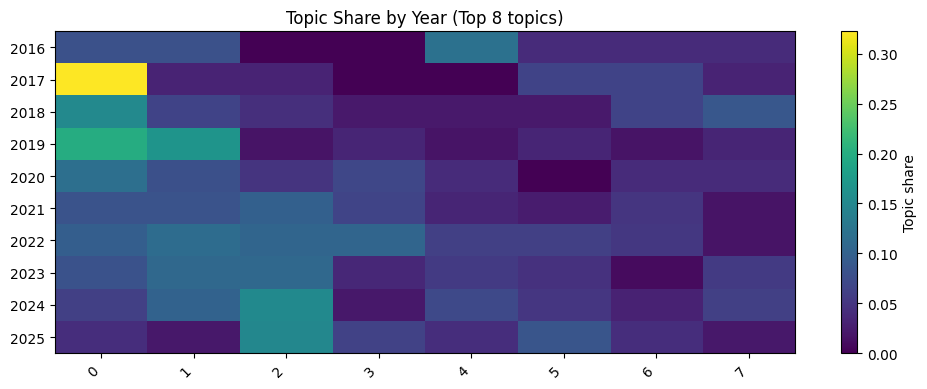

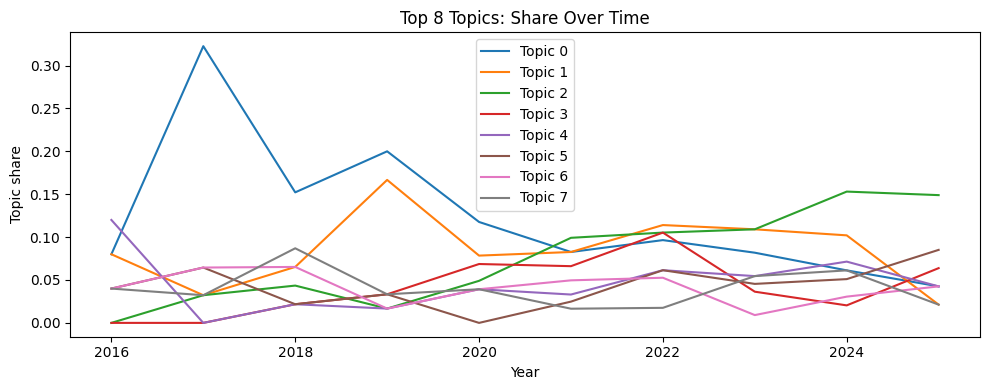

,topic_id,share_2016,share_2025,delta
2,2,0.00,0.148936,0.148936
3,3,0.00,0.063830,0.063830
5,5,0.04,0.085106,0.045106
6,6,0.04,0.042553,0.002553
7,7,0.04,0.021277,-0.018723
0,0,0.08,0.042553,-0.037447
1,1,0.08,0.021277,-0.058723
4,4,0.12,0.042553,-0.077447


In [64]:
# ============================================================
# CELL T4 — Visualize conceptual evolution
# 1) Heatmap for top topics (by overall count)
# 2) Line chart for top-K topics over time
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Choose top topics by global frequency (exclude -1 if you want)
topic_info = topic_model.get_topic_info()
topic_info_no_out = topic_info[topic_info["Topic"] != -1].copy()

TOP_K = 8
top_topics = topic_info_no_out.sort_values("Count", ascending=False)["Topic"].head(TOP_K).tolist()

# Build pivot again (year x topic) but only top topics
pivot_top = pivot[top_topics].copy()

# --- Heatmap ---
plt.figure(figsize=(10, 4))
plt.imshow(pivot_top.values, aspect="auto")
plt.xticks(range(len(top_topics)), [str(t) for t in top_topics], rotation=45, ha="right")
plt.yticks(range(len(pivot_top.index)), [str(y) for y in pivot_top.index])
plt.colorbar(label="Topic share")
plt.title(f"Topic Share by Year (Top {TOP_K} topics)")
plt.tight_layout()
plt.show()

# --- Line trends ---
plt.figure(figsize=(10, 4))
for t in top_topics:
    plt.plot(pivot_top.index, pivot_top[t], label=f"Topic {t}")
plt.xlabel("Year")
plt.ylabel("Topic share")
plt.title(f"Top {TOP_K} Topics: Share Over Time")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# Provide a small, report-friendly table: changes from 2016 to 2025
year_min = int(pivot_top.index.min())
year_max = int(pivot_top.index.max())
delta_tbl = pd.DataFrame({
    "topic_id": top_topics,
    f"share_{year_min}": [pivot_top.loc[year_min, t] if year_min in pivot_top.index else np.nan for t in top_topics],
    f"share_{year_max}": [pivot_top.loc[year_max, t] if year_max in pivot_top.index else np.nan for t in top_topics],
})
delta_tbl["delta"] = delta_tbl[f"share_{year_max}"] - delta_tbl[f"share_{year_min}"]

display(delta_tbl.sort_values("delta", ascending=False))


In [8]:
# ============================================================
# CELL 9A — Report Findings: Load scored dataset + validation
# ============================================================
# Goal:
# - Load the scored dataset produced in Cell 8
# - Validate that required columns exist
# - Create an output directory structure for figures/tables/reports
# ============================================================

import os
import json
import numpy as np
import pandas as pd

# ---------
# Paths (be careful: match your actual filenames)
# ---------
SCORED_CSV_PATH = "./outputs_p7/machine_learning_scored_2016_2025.csv"

OUT_DIR = "./outputs_p7/report_findings"
FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")
REP_DIR = os.path.join(OUT_DIR, "reports")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(REP_DIR, exist_ok=True)

# ---------
# Load scored dataset
# ---------
df = pd.read_csv(SCORED_CSV_PATH)

print("Loaded scored dataset:", df.shape)
print("Columns:", list(df.columns))

# ---------
# Required columns for Report Findings
# ---------
REQUIRED_COLS = ["year", "alignment_score_topk_mean", "title", "abstract", "doi"]
missing = [c for c in REQUIRED_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns in scored CSV: {missing}")

# ---------
# Basic validation
# ---------
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["alignment_score_topk_mean"] = pd.to_numeric(df["alignment_score_topk_mean"], errors="coerce")

print("\nQuick checks:")
print(" - Rows with NaN year:", int(df["year"].isna().sum()))
print(" - Rows with NaN score:", int(df["alignment_score_topk_mean"].isna().sum()))
print(" - Year min/max:", float(df["year"].min()), float(df["year"].max()))
print(" - Score min/max:", float(df["alignment_score_topk_mean"].min()), float(df["alignment_score_topk_mean"].max()))

# Drop any invalid rows (should be none, but keep the pipeline robust)
before = len(df)
df = df.dropna(subset=["year", "alignment_score_topk_mean"]).copy()
after = len(df)
print(f"\n✅ After dropping NaN year/score: {after} (dropped {before-after})")

# Save a small validation snapshot for grading/reproducibility
validation_summary = {
    "scored_csv_path": SCORED_CSV_PATH,
    "rows_loaded": int(before),
    "rows_after_dropna": int(after),
    "year_min": float(df["year"].min()),
    "year_max": float(df["year"].max()),
    "score_min": float(df["alignment_score_topk_mean"].min()),
    "score_max": float(df["alignment_score_topk_mean"].max()),
    "score_mean": float(df["alignment_score_topk_mean"].mean()),
    "score_std": float(df["alignment_score_topk_mean"].std(ddof=1)),
}
with open(os.path.join(REP_DIR, "validation_summary.json"), "w", encoding="utf-8") as f:
    json.dump(validation_summary, f, indent=2)

print("\n✅ Saved:", os.path.join(REP_DIR, "validation_summary.json"))


Loaded scored dataset: (754, 20)
Columns: ['doi', 'paperId', 'title', 'abstract', 'year', 'venue_name', 'publicationTypes', 'authors', 'url', '_status', 'doi_norm', 'container_title_crossref', 'year_crossref', 'type_crossref', 'title_crossref', 'year_s2', 'year_cr', 'year_final', 'alignment_score_max', 'alignment_score_topk_mean']

Quick checks:
 - Rows with NaN year: 0
 - Rows with NaN score: 0
 - Year min/max: 2016.0 2025.0
 - Score min/max: 0.1261975 0.627483

✅ After dropping NaN year/score: 754 (dropped 0)

✅ Saved: ./outputs_p7/report_findings/reports/validation_summary.json


✅ Saved: ./outputs_p7/report_findings/tables/score_distribution_summary.csv
   count      mean    median       std       min       max       p10  \
0    754  0.351379  0.350573  0.071186  0.126197  0.627483  0.263275   

        p25       p75       p90  
0  0.305338  0.402525  0.442651  


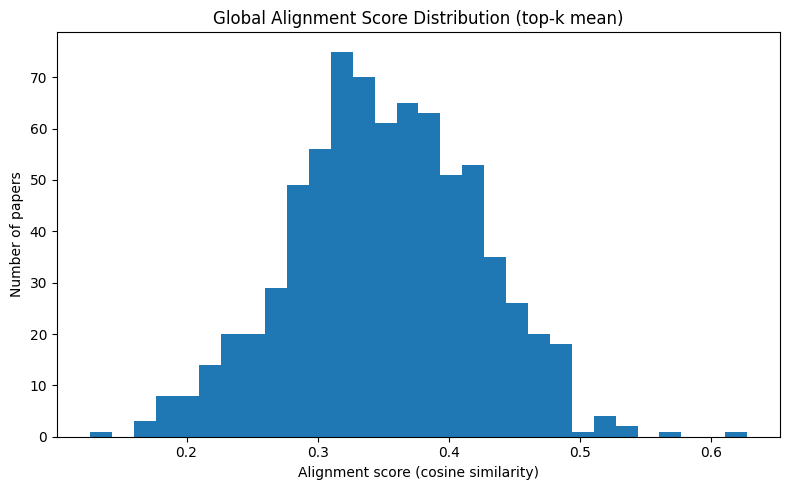

✅ Saved figure: ./outputs_p7/report_findings/figures/score_histogram_global.png


In [9]:
# ============================================================
# CELL 9B — Score distribution analysis (global)
# ============================================================
# Goal:
# - Compute descriptive statistics + percentiles
# - Plot histogram of alignment scores (global)
# - Save statistics table + figure
# ============================================================

import matplotlib.pyplot as plt

score_col = "alignment_score_topk_mean"
scores = df[score_col].to_numpy()

# ---------
# Descriptive statistics and percentiles
# ---------
desc = {
    "count": int(len(scores)),
    "mean": float(np.mean(scores)),
    "median": float(np.median(scores)),
    "std": float(np.std(scores, ddof=1)),
    "min": float(np.min(scores)),
    "max": float(np.max(scores)),
    "p10": float(np.percentile(scores, 10)),
    "p25": float(np.percentile(scores, 25)),
    "p75": float(np.percentile(scores, 75)),
    "p90": float(np.percentile(scores, 90)),
}

desc_df = pd.DataFrame([desc])
desc_path = os.path.join(TAB_DIR, "score_distribution_summary.csv")
desc_df.to_csv(desc_path, index=False)

print("✅ Saved:", desc_path)
print(desc_df)

# ---------
# Histogram plot (no seaborn)
# ---------
plt.figure(figsize=(8, 5))
plt.hist(scores, bins=30)
plt.title("Global Alignment Score Distribution (top-k mean)")
plt.xlabel("Alignment score (cosine similarity)")
plt.ylabel("Number of papers")

fig_path = os.path.join(FIG_DIR, "score_histogram_global.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("✅ Saved figure:", fig_path)


✅ Saved: ./outputs_p7/report_findings/tables/yearly_alignment_summary.csv
   year  count      mean    median       std
0  2016     25  0.355021  0.361613  0.065044
1  2017     31  0.383894  0.390611  0.065017
2  2018     46  0.365180  0.364463  0.067933
3  2019     60  0.362715  0.359985  0.065484
4  2020    102  0.353440  0.343497  0.076486
5  2021    121  0.364210  0.371335  0.068985
6  2022    114  0.339228  0.336655  0.083416
7  2023    110  0.345210  0.347473  0.058560
8  2024     98  0.340580  0.337975  0.071396
9  2025     47  0.328944  0.324511  0.063296


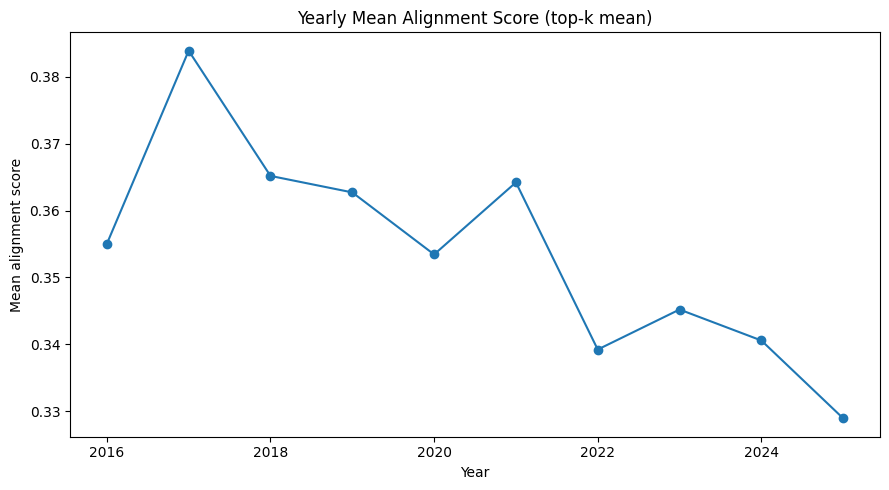

✅ Saved figure: ./outputs_p7/report_findings/figures/yearly_mean_alignment.png


/tmp/ipython-input-1422948830.py:51: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_year, labels=[str(int(y)) for y in years_sorted], showfliers=True)


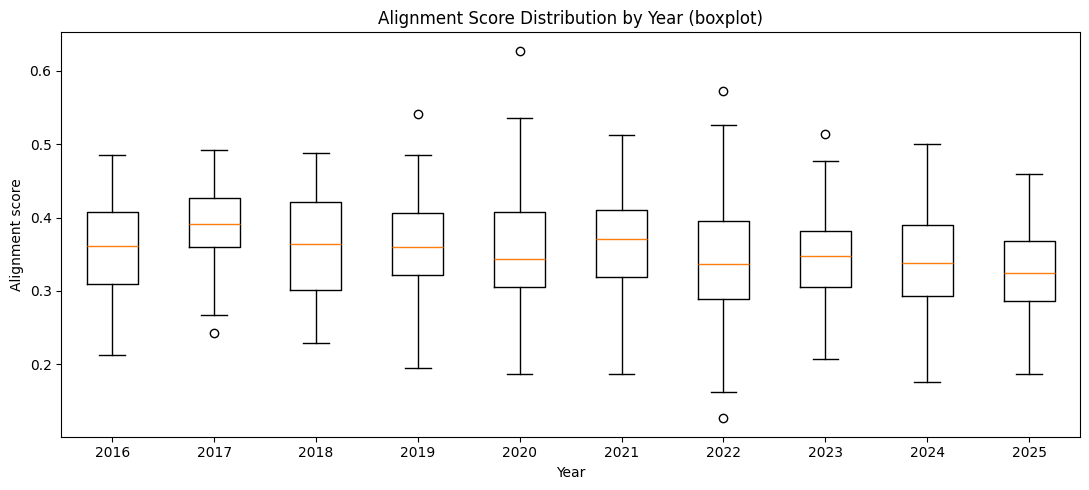

✅ Saved figure: ./outputs_p7/report_findings/figures/yearly_alignment_boxplot.png

Linear regression (year -> score):
 - slope: -0.004515123743540166
 - intercept: 9.477683988870941
 - R^2: 0.021414197720860284

Spearman correlation (year vs score):
 - rho: -0.14230667776045972
 - p-value: 8.814674418628385e-05

✅ Saved: ./outputs_p7/report_findings/reports/drift_indicators.json


In [10]:
# ============================================================
# CELL 9C — Yearly trend analysis (drift evidence)
# ============================================================
# Goal:
# - Compute yearly mean/median and dispersion
# - Plot yearly mean trend
# - Plot yearly boxplot (distribution per year)
# - Add quantitative drift indicators:
#   * linear regression slope
#   * Spearman correlation (year vs score)
# ============================================================

import matplotlib.pyplot as plt

# Aggregate per year
yearly = (
    df.groupby("year")[score_col]
      .agg(["count", "mean", "median", "std"])
      .reset_index()
      .sort_values("year")
)

yearly_path = os.path.join(TAB_DIR, "yearly_alignment_summary.csv")
yearly.to_csv(yearly_path, index=False)

print("✅ Saved:", yearly_path)
print(yearly)

# ---------
# Plot 1: Yearly mean alignment
# ---------
plt.figure(figsize=(9, 5))
plt.plot(yearly["year"], yearly["mean"], marker="o")
plt.title("Yearly Mean Alignment Score (top-k mean)")
plt.xlabel("Year")
plt.ylabel("Mean alignment score")

fig_path = os.path.join(FIG_DIR, "yearly_mean_alignment.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()
print("✅ Saved figure:", fig_path)

# ---------
# Plot 2: Yearly distribution (boxplot)
# ---------
years_sorted = sorted(df["year"].unique())
data_by_year = [df.loc[df["year"] == y, score_col].to_numpy() for y in years_sorted]

plt.figure(figsize=(11, 5))
plt.boxplot(data_by_year, labels=[str(int(y)) for y in years_sorted], showfliers=True)
plt.title("Alignment Score Distribution by Year (boxplot)")
plt.xlabel("Year")
plt.ylabel("Alignment score")

fig_path = os.path.join(FIG_DIR, "yearly_alignment_boxplot.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()
print("✅ Saved figure:", fig_path)

# ---------
# Quantitative drift indicators
# ---------

# 1) Simple linear regression slope (year -> score)
# We use numpy polyfit for a minimal dependency approach.
x = df["year"].to_numpy()
y = df[score_col].to_numpy()

slope, intercept = np.polyfit(x, y, 1)
y_hat = slope * x + intercept
residuals = y - y_hat

# R^2 computation
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1.0 - (ss_res / ss_tot)

print("\nLinear regression (year -> score):")
print(" - slope:", float(slope))
print(" - intercept:", float(intercept))
print(" - R^2:", float(r2))

# 2) Spearman correlation (more robust than Pearson for monotonic drift)
# Try scipy; if not available, fall back to a simple rank-correlation implementation.
try:
    from scipy.stats import spearmanr
    rho, pval = spearmanr(x, y)
    print("\nSpearman correlation (year vs score):")
    print(" - rho:", float(rho))
    print(" - p-value:", float(pval))
except Exception as e:
    print("\n⚠️ scipy not available for Spearman. Error:", str(e))
    print("Fallback: skipping Spearman.")

# Save drift indicators
drift_report = {
    "linear_regression_slope": float(slope),
    "linear_regression_intercept": float(intercept),
    "linear_regression_r2": float(r2),
}

# If scipy worked, also store rho/pval
try:
    drift_report["spearman_rho"] = float(rho)
    drift_report["spearman_pvalue"] = float(pval)
except NameError:
    pass

drift_path = os.path.join(REP_DIR, "drift_indicators.json")
with open(drift_path, "w", encoding="utf-8") as f:
    json.dump(drift_report, f, indent=2)

print("\n✅ Saved:", drift_path)


Kruskal-Wallis test across years:
 - statistic: 24.622470469622385
 - p-value: 0.003418447969094914
✅ Saved: ./outputs_p7/report_findings/reports/kruskal_wallis_years.json

✅ Saved: ./outputs_p7/report_findings/tables/yearly_mean_bootstrap_ci95.csv
   year  count      mean  ci95_low  ci95_high
0  2016     25  0.355021  0.329468   0.379596
1  2017     31  0.383894  0.361936   0.403998
2  2018     46  0.365180  0.345669   0.385324
3  2019     60  0.362715  0.346200   0.379560
4  2020    102  0.353440  0.338878   0.369139
5  2021    121  0.364210  0.351209   0.376593
6  2022    114  0.339228  0.323813   0.354288
7  2023    110  0.345210  0.334817   0.356306
8  2024     98  0.340580  0.326504   0.354950
9  2025     47  0.328944  0.311662   0.346255


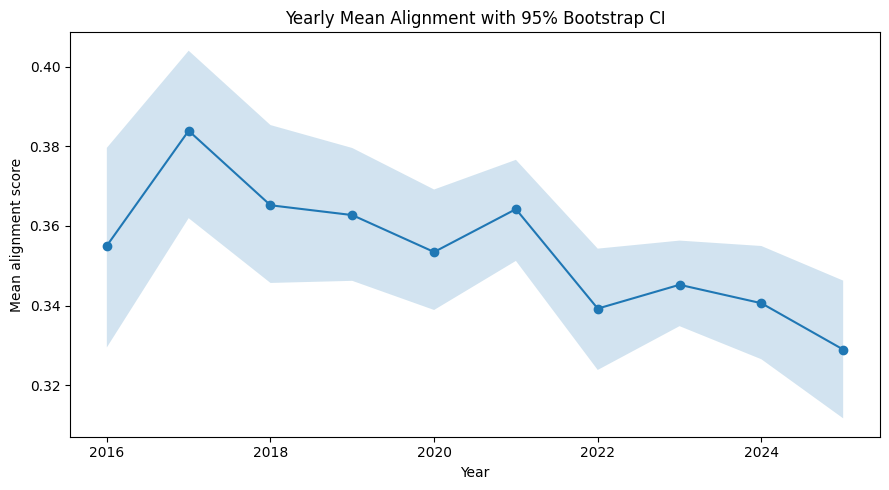

✅ Saved figure: ./outputs_p7/report_findings/figures/yearly_mean_with_ci95.png


In [11]:
# ============================================================
# CELL 9D — Statistical evidence for drift (tests + bootstrap CI)
# ============================================================
# Goal:
# - Test if score distributions differ across years (Kruskal-Wallis)
# - Compute bootstrap 95% CI for yearly mean scores (uncertainty bands)
# ============================================================

import numpy as np
import pandas as pd

years_sorted = sorted(df["year"].unique())
groups = [df.loc[df["year"] == y, score_col].to_numpy() for y in years_sorted]

# ---------
# Kruskal-Wallis test (non-parametric ANOVA alternative)
# ---------
kw_result = {"test": "kruskal_wallis", "statistic": None, "pvalue": None}

try:
    from scipy.stats import kruskal
    stat, p = kruskal(*groups)
    kw_result["statistic"] = float(stat)
    kw_result["pvalue"] = float(p)
    print("Kruskal-Wallis test across years:")
    print(" - statistic:", float(stat))
    print(" - p-value:", float(p))
except Exception as e:
    print("⚠️ scipy not available for Kruskal-Wallis. Error:", str(e))
    print("Skipping this test.")

kw_path = os.path.join(REP_DIR, "kruskal_wallis_years.json")
with open(kw_path, "w", encoding="utf-8") as f:
    json.dump(kw_result, f, indent=2)

print("✅ Saved:", kw_path)

# ---------
# Bootstrap 95% CI for yearly mean
# ---------
def bootstrap_mean_ci(arr, n_boot=2000, alpha=0.05, seed=42):
    """
    Compute bootstrap CI for the mean of arr.
    Returns: (mean, lower, upper)
    """
    rng = np.random.default_rng(seed)
    arr = np.asarray(arr)
    if len(arr) == 0:
        return (np.nan, np.nan, np.nan)
    boot_means = []
    for _ in range(n_boot):
        sample = rng.choice(arr, size=len(arr), replace=True)
        boot_means.append(np.mean(sample))
    boot_means = np.asarray(boot_means)
    lower = np.quantile(boot_means, alpha/2)
    upper = np.quantile(boot_means, 1 - alpha/2)
    return (float(np.mean(arr)), float(lower), float(upper))

rows = []
for y in years_sorted:
    arr = df.loc[df["year"] == y, score_col].to_numpy()
    mean_, lo, hi = bootstrap_mean_ci(arr, n_boot=2000, alpha=0.05, seed=42)
    rows.append({"year": int(y), "count": int(len(arr)), "mean": mean_, "ci95_low": lo, "ci95_high": hi})

ci_df = pd.DataFrame(rows).sort_values("year")
ci_path = os.path.join(TAB_DIR, "yearly_mean_bootstrap_ci95.csv")
ci_df.to_csv(ci_path, index=False)

print("\n✅ Saved:", ci_path)
print(ci_df)

# ---------
# Plot: Yearly mean with CI band
# ---------
import matplotlib.pyplot as plt

plt.figure(figsize=(9, 5))
plt.plot(ci_df["year"], ci_df["mean"], marker="o")
plt.fill_between(ci_df["year"], ci_df["ci95_low"], ci_df["ci95_high"], alpha=0.2)
plt.title("Yearly Mean Alignment with 95% Bootstrap CI")
plt.xlabel("Year")
plt.ylabel("Mean alignment score")

fig_path = os.path.join(FIG_DIR, "yearly_mean_with_ci95.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=200)
plt.show()

print("✅ Saved figure:", fig_path)


In [12]:
# ============================================================
# CELL 9E — Outlier papers extraction (qualitative validation prep)
# ============================================================
# Goal:
# - Select lowest-N alignment score papers as potential outliers
# - Save a grader-friendly CSV including:
#   year, title, doi, score, url, short abstract excerpt
# - This supports the "outlier qualitative validation" requirement
# ============================================================

import pandas as pd

N_OUTLIERS = 20

outliers = (
    df.sort_values(score_col, ascending=True)
      .head(N_OUTLIERS)
      .copy()
)

# Create a short excerpt to make manual review easier
outliers["abstract_excerpt"] = outliers["abstract"].astype(str).str.replace("\n", " ").str.slice(0, 300)

keep_cols = ["year", "alignment_score_topk_mean", "doi", "title", "url", "venue_name", "abstract_excerpt"]
keep_cols = [c for c in keep_cols if c in outliers.columns]

outliers_view = outliers[keep_cols].copy()

out_path = os.path.join(TAB_DIR, f"outliers_lowest_{N_OUTLIERS}.csv")
outliers_view.to_csv(out_path, index=False)

print("✅ Saved outlier review sheet:", out_path)
outliers_view


✅ Saved outlier review sheet: ./outputs_p7/report_findings/tables/outliers_lowest_20.csv


,year,alignment_score_topk_mean,doi,title,url,venue_name,abstract_excerpt
623,2022,0.126197,10.1007/s10994-022-06235-3,3DVerifier: efficient robustness verification ...,https://www.semanticscholar.org/paper/86850f55...,Machine-mediated learning,3D point cloud models are widely applied in sa...
279,2022,0.162599,10.1007/s10994-022-06160-5,Heterogeneous graph embedding with single-leve...,https://www.semanticscholar.org/paper/30926e65...,Machine-mediated learning,There has been an increasing interest in devel...
530,2022,0.171384,10.1007/s10994-023-06435-5,Style spectroscope: improve interpretability a...,https://www.semanticscholar.org/paper/506c1308...,Machine-mediated learning,Universal style transfer (UST) infuses styles ...
167,2024,0.175687,10.1007/s10994-023-06499-3,When are they coming? Understanding and foreca...,https://www.semanticscholar.org/paper/8f5091aa...,Machine-mediated learning,Futbol Club Barcelona operates the largest sta...
365,2022,0.179925,10.1007/s10994-023-06508-5,Differentially private Riemannian optimization,https://www.semanticscholar.org/paper/ad5f16c8...,Machine-mediated learning,"In this paper, we study the differentially pri..."
46,2022,0.183160,10.1007/s10994-022-06252-2,DIMBA: discretely masked black-box attack in s...,https://www.semanticscholar.org/paper/38170bc2...,Machine-mediated learning,The adversarial attack can force a CNN-based m...
615,2024,0.183238,10.1007/s10994-024-06575-2,PROUD: PaRetO-gUided diffusion model for multi...,https://www.semanticscholar.org/paper/37afc980...,Machine-mediated learning,Recent advancements in the realm of deep gener...
367,2022,0.185434,10.1007/s10994-022-06258-w,Riemannian block SPD coupling manifold and its...,https://www.semanticscholar.org/paper/b7fd072f...,Machine-mediated learning,"In this work, we study the optimal transport (..."
731,2020,0.186300,10.1007/s10994-021-05970-3,"SPEED: secure, PrivatE, and efficient deep lea...",https://www.semanticscholar.org/paper/aa267677...,Machine-mediated learning,We introduce a deep learning framework able to...
480,2025,0.186651,10.1007/s10994-024-06648-2,Interactive sequential generative models for t...,https://www.semanticscholar.org/paper/1d7dedae...,Machine-mediated learning,Understanding spatiotemporal coordination of p...


In [14]:
import os
import numpy as np
import pandas as pd
import re

RAW_ENRICH_PATH = "machine_learning_s2_enrichment_checkpoint_2016_2025.csv"
CURATED_PATH    = "machine_learning_abstracts_2016_2025.csv"
SCORED_PATH     = "outputs_p7/machine_learning_scored_2016_2025.csv"  # sende böyle kaydedildi

for p in [RAW_ENRICH_PATH, CURATED_PATH, SCORED_PATH]:
    print(p, "->", "OK" if os.path.exists(p) else "MISSING")

df_raw = pd.read_csv(RAW_ENRICH_PATH)
df_cur = pd.read_csv(CURATED_PATH)
df_sc  = pd.read_csv(SCORED_PATH)

print("raw:", df_raw.shape, "curated:", df_cur.shape, "scored:", df_sc.shape)


machine_learning_s2_enrichment_checkpoint_2016_2025.csv -> OK
machine_learning_abstracts_2016_2025.csv -> OK
outputs_p7/machine_learning_scored_2016_2025.csv -> OK
raw: (1385, 10) curated: (754, 18) scored: (754, 20)


In [15]:
START_YEAR, END_YEAR = 2016, 2025

def pick_year(df):
    # year_final varsa onu, yoksa year sütununu kullan
    for col in ["year_final", "year", "year_s2", "year_crossref"]:
        if col in df.columns:
            y = pd.to_numeric(df[col], errors="coerce")
            if y.notna().sum() > 0:
                return y
    return pd.Series([np.nan]*len(df))

df_raw["_year"] = pick_year(df_raw)
df_cur["_year"] = pick_year(df_cur)

df_raw_y = df_raw[(df_raw["_year"] >= START_YEAR) & (df_raw["_year"] <= END_YEAR)].copy()
df_cur_y = df_cur[(df_cur["_year"] >= START_YEAR) & (df_cur["_year"] <= END_YEAR)].copy()

print("raw after year filter:", df_raw_y.shape)
print("curated after year filter:", df_cur_y.shape)


raw after year filter: (1359, 11)
curated after year filter: (754, 19)


In [16]:
before = df_raw_y["_year"].value_counts().sort_index()
after  = df_cur_y["_year"].value_counts().sort_index()

tbl = pd.DataFrame({
    "before_year_filter": before,
    "after_abstract_filter": after
}).fillna(0).astype(int)

tbl["retention_rate"] = (tbl["after_abstract_filter"] / tbl["before_year_filter"]).replace([np.inf], np.nan)
tbl["dropout_rate"]   = 1 - tbl["retention_rate"]

tbl


,before_year_filter,after_abstract_filter,retention_rate,dropout_rate
_year,,,,
2016.0,78,25,0.320513,0.679487
2017.0,89,31,0.348315,0.651685
2018.0,94,46,0.489362,0.510638
2019.0,100,60,0.600000,0.400000
2020.0,129,102,0.790698,0.209302
2021.0,172,121,0.703488,0.296512
2022.0,175,114,0.651429,0.348571
2023.0,163,110,0.674847,0.325153
2024.0,146,98,0.671233,0.328767


In [18]:
tbl2 = tbl.reset_index().copy()

# The year column is the first column after reset_index()
year_col = tbl2.columns[0]
tbl2 = tbl2.rename(columns={year_col: "year"})

tbl2["year"] = pd.to_numeric(tbl2["year"], errors="coerce").astype(int)

corr = tbl2["year"].corr(tbl2["retention_rate"])
print("Correlation(year, retention_rate) =", corr)

print("Lowest retention years:")
print(tbl2.sort_values("retention_rate").head(3))

print("\nHighest retention years:")
print(tbl2.sort_values("retention_rate", ascending=False).head(3))


Correlation(year, retention_rate) = 0.22580168713854065
Lowest retention years:
   year  before_year_filter  after_abstract_filter  retention_rate  \
9  2025                 213                     47        0.220657   
0  2016                  78                     25        0.320513   
1  2017                  89                     31        0.348315   

   dropout_rate  
9      0.779343  
0      0.679487  
1      0.651685  

Highest retention years:
   year  before_year_filter  after_abstract_filter  retention_rate  \
4  2020                 129                    102        0.790698   
5  2021                 172                    121        0.703488   
7  2023                 163                    110        0.674847   

   dropout_rate  
4      0.209302  
5      0.296512  
7      0.325153  


In [19]:
df_sc["abstract"] = df_sc["abstract"].fillna("").astype(str)

patterns = {
    "has_backslash": r"\\",
    "has_documentclass": r"\\documentclass",
    "has_begin_end": r"\\begin\{|\}\\end\{",
    "has_curly_braces": r"\{|\}",
    "has_math_mode": r"\$.*?\$",
}

for name, pat in patterns.items():
    df_sc[name] = df_sc["abstract"].str.contains(pat, regex=True)

df_sc["abstract_len"] = df_sc["abstract"].str.len()
df_sc["latex_noise_any"] = df_sc[list(patterns.keys())].any(axis=1)

print("Overall latex_noise_any rate:", df_sc["latex_noise_any"].mean())
df_sc[list(patterns.keys()) + ["latex_noise_any"]].mean().sort_values(ascending=False)


Overall latex_noise_any rate: 0.1286472148541114


,0
has_math_mode,0.128647
latex_noise_any,0.128647
has_backslash,0.123342
has_curly_braces,0.119363
has_documentclass,0.106101
has_begin_end,0.106101


In [20]:
# en düşük 20 skor
out = df_sc.nsmallest(20, "alignment_score_topk_mean").copy()

summary = {
    "overall_latex_noise_rate": float(df_sc["latex_noise_any"].mean()),
    "outlier20_latex_noise_rate": float(out["latex_noise_any"].mean()),
    "overall_mean_len": float(df_sc["abstract_len"].mean()),
    "outlier20_mean_len": float(out["abstract_len"].mean()),
}

summary


{'overall_latex_noise_rate': 0.1286472148541114,
 'outlier20_latex_noise_rate': 0.1,
 'overall_mean_len': 1386.4098143236074,
 'outlier20_mean_len': 1308.3}

In [21]:
out_noise = out[out["latex_noise_any"]].copy()
out_noise[["year_final","alignment_score_topk_mean","title","doi","latex_noise_any","abstract"]].head(5)


,year_final,alignment_score_topk_mean,title,doi,latex_noise_any,abstract
468,2022.0,0.189048,Semi-Lipschitz functions and machine learning ...,10.1007/s10994-022-06130-x,True,Consider a directed tree U\documentclass[12pt]...
28,2022.0,0.193065,Efficient private SCO for heavy-tailed data vi...,10.1007/s10994-024-06617-9,True,We consider stochastic convex optimization for...


In [22]:
df_sc["year_int"] = pd.to_numeric(df_sc["year_final"], errors="coerce").astype(int)

corr_ls = df_sc["abstract_len"].corr(df_sc["alignment_score_topk_mean"])
print("Correlation(abstract_len, score) =", corr_ls)


Correlation(abstract_len, score) = -0.008923989245613483


In [23]:
# quantile bin: kısa/orta/uzun gibi
df_sc["len_bin"] = pd.qcut(df_sc["abstract_len"], q=5, duplicates="drop")

bin_tbl = df_sc.groupby("len_bin")["alignment_score_topk_mean"].agg(["count","mean","median","std"]).reset_index()
bin_tbl


/tmp/ipython-input-95327647.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_tbl = df_sc.groupby("len_bin")["alignment_score_topk_mean"].agg(["count","mean","median","std"]).reset_index()


,len_bin,count,mean,median,std
0,"(82.999, 1041.6]",151,0.352228,0.350391,0.069080
1,"(1041.6, 1245.2]",151,0.351676,0.346874,0.074112
2,"(1245.2, 1419.8]",150,0.344358,0.346170,0.066560
3,"(1419.8, 1654.4]",151,0.355783,0.356518,0.070839
4,"(1654.4, 4390.0]",151,0.352805,0.357265,0.075389


In [24]:
len_by_year = df_sc.groupby("year_int")["abstract_len"].agg(["count","mean","median","std"]).reset_index()
len_by_year


,year_int,count,mean,median,std
0,2016,25,1257.280000,1193.0,327.285874
1,2017,31,1596.967742,1440.0,765.939357
2,2018,46,1360.434783,1284.0,527.084039
3,2019,60,1361.766667,1250.0,477.226144
4,2020,102,1355.176471,1314.5,447.556853
5,2021,121,1384.760331,1279.0,509.937382
6,2022,114,1383.096491,1329.5,517.847348
7,2023,110,1395.890909,1370.5,484.316114
8,2024,98,1405.204082,1344.5,374.994157
9,2025,47,1391.787234,1346.0,337.171930


In [25]:
# Basit lineer düzeltme: score ~ a + b*log(len)
df_sc["log_len"] = np.log1p(df_sc["abstract_len"])

# numpy ile OLS
X = np.vstack([np.ones(len(df_sc)), df_sc["log_len"].values]).T
y = df_sc["alignment_score_topk_mean"].values
beta = np.linalg.lstsq(X, y, rcond=None)[0]  # [a, b]

df_sc["score_len_adjusted"] = df_sc["alignment_score_topk_mean"] - (beta[0] + beta[1]*df_sc["log_len"])  # residual

print("OLS beta a,b:", beta)

adj_year = df_sc.groupby("year_int")["score_len_adjusted"].mean()
raw_year = df_sc.groupby("year_int")["alignment_score_topk_mean"].mean()

print("Raw yearly mean:\n", raw_year)
print("\nLen-adjusted yearly mean:\n", adj_year)


OLS beta a,b: [ 3.52602734e-01 -1.70376887e-04]
Raw yearly mean:
 year_int
2016    0.355021
2017    0.383894
2018    0.365180
2019    0.362715
2020    0.353440
2021    0.364210
2022    0.339228
2023    0.345210
2024    0.340580
2025    0.328944
Name: alignment_score_topk_mean, dtype: float64

Len-adjusted yearly mean:
 year_int
2016    0.003629
2017    0.032532
2018    0.013796
2019    0.011332
2020    0.002055
2021    0.012831
2022   -0.012153
2023   -0.006167
2024   -0.010794
2025   -0.022430
Name: score_len_adjusted, dtype: float64


In [26]:
# ============================================================
# CELL A1 — Load scored dataset (fast reload)
# Purpose:
# - Re-load the already scored dataset (no re-embedding)
# - Prepare clean year_int and score columns
# ============================================================

import os
import json
import numpy as np
import pandas as pd

SCORED_PATH = "outputs_p7/machine_learning_scored_2016_2025.csv"
assert os.path.exists(SCORED_PATH), f"File not found: {SCORED_PATH}"

df_sc = pd.read_csv(SCORED_PATH)

# Use year_final if present; fall back to year
year_col = "year_final" if "year_final" in df_sc.columns else "year"
df_sc["year_int"] = pd.to_numeric(df_sc[year_col], errors="coerce").astype("Int64")

# Choose the main score we used in the report
SCORE_COL = "alignment_score_topk_mean"
assert SCORE_COL in df_sc.columns, f"Missing score column: {SCORE_COL}"

# Drop any missing essentials (should be zero based on your checks)
df_sc = df_sc.dropna(subset=["year_int", SCORE_COL]).copy()
df_sc["year_int"] = df_sc["year_int"].astype(int)

print("Loaded scored dataset:", df_sc.shape)
print("Years:", df_sc["year_int"].min(), "-", df_sc["year_int"].max())
print("Score min/max:", float(df_sc[SCORE_COL].min()), float(df_sc[SCORE_COL].max()))


Loaded scored dataset: (754, 21)
Years: 2016 - 2025
Score min/max: 0.1261975 0.627483


   year_int  count      mean    median       std coverage_flag
0      2016     25  0.355021  0.361613  0.065044  low_coverage
1      2017     31  0.383894  0.390611  0.065017  low_coverage
2      2018     46  0.365180  0.364463  0.067933  low_coverage
3      2019     60  0.362715  0.359985  0.065484            ok
4      2020    102  0.353440  0.343497  0.076486            ok
5      2021    121  0.364210  0.371335  0.068985            ok
6      2022    114  0.339228  0.336655  0.083416            ok
7      2023    110  0.345210  0.347473  0.058560            ok
8      2024     98  0.340580  0.337975  0.071396            ok
9      2025     47  0.328944  0.324511  0.063296  low_coverage


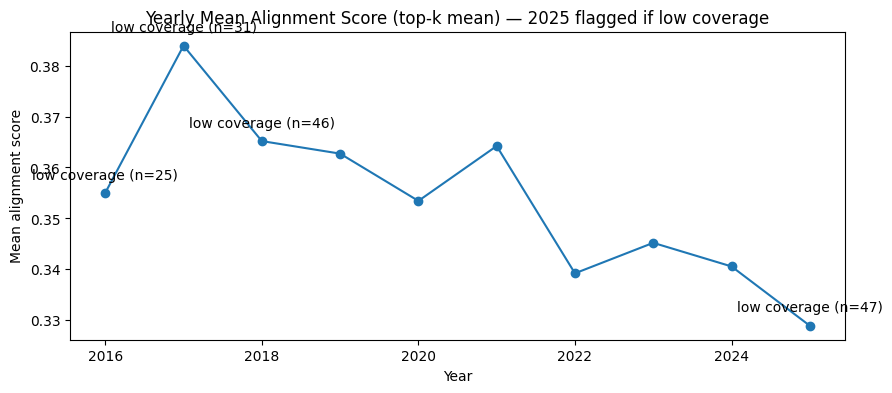

In [27]:
# ============================================================
# CELL A2 — Yearly mean plot with 2025 flagged as "low coverage"
# ============================================================

import matplotlib.pyplot as plt

yearly = df_sc.groupby("year_int")[SCORE_COL].agg(["count", "mean", "median", "std"]).reset_index()

# Define a "low coverage" threshold (you can justify this in the report)
# Example: fewer than 60 retained abstracts in a year is considered low coverage.
LOW_COVERAGE_N = 60
yearly["coverage_flag"] = np.where(yearly["count"] < LOW_COVERAGE_N, "low_coverage", "ok")

print(yearly)

plt.figure(figsize=(10, 4))
plt.plot(yearly["year_int"], yearly["mean"], marker="o")
plt.title("Yearly Mean Alignment Score (top-k mean) — 2025 flagged if low coverage")
plt.xlabel("Year")
plt.ylabel("Mean alignment score")

# Annotate low coverage years directly on the plot
for _, r in yearly.iterrows():
    if r["coverage_flag"] == "low_coverage":
        plt.annotate(f"low coverage (n={int(r['count'])})",
                     (r["year_int"], r["mean"]),
                     textcoords="offset points", xytext=(0, 10), ha="center")

plt.show()


In [30]:
# ============================================================
# CELL A3b — Pretty table view for drift tests
# - Converts the JSON-like dict to a clean pandas table
# - Prints nicely + saves CSV + saves Markdown (report-friendly)
# ============================================================

import pandas as pd
import os

# results dict (CELL A3'ten geliyor) -> tabloya çevir
rows = []
for label, d in results.items():
    rows.append({
        "subset": label,
        "years": f"{min(d['years'])}-{max(d['years'])}",
        "n_years": len(d["years"]),
        "kruskal_stat": d["kruskal_stat"],
        "kruskal_p": d["kruskal_p"],
        "trend_slope_per_year": d["trend_slope_b_per_year"],
    })

df_drift = pd.DataFrame(rows)

# Daha okunaklı format
df_show = df_drift.copy()
df_show["kruskal_stat"] = df_show["kruskal_stat"].map(lambda x: f"{x:.3f}")
df_show["kruskal_p"] = df_show["kruskal_p"].map(lambda x: f"{x:.4f}")
df_show["trend_slope_per_year"] = df_show["trend_slope_per_year"].map(lambda x: f"{x:.6f}")

display(df_show)

# Kaydet (rapora koymak için)
OUT_DIR = "outputs_p7/report_findings/tables"
os.makedirs(OUT_DIR, exist_ok=True)

csv_path = f"{OUT_DIR}/drift_tests_all_vs_2016_2024_table.csv"
md_path  = f"{OUT_DIR}/drift_tests_all_vs_2016_2024_table.md"

df_drift.to_csv(csv_path, index=False)
with open(md_path, "w", encoding="utf-8") as f:
    f.write(df_show.to_markdown(index=False))

print("Saved:", csv_path)
print("Saved:", md_path)


,subset,years,n_years,kruskal_stat,kruskal_p,trend_slope_per_year
0,all_years,2016-2025,10,24.622,0.0034,-0.004227
1,years_2016_2024,2016-2024,9,19.169,0.0140,-0.003737


Saved: outputs_p7/report_findings/tables/drift_tests_all_vs_2016_2024_table.csv
Saved: outputs_p7/report_findings/tables/drift_tests_all_vs_2016_2024_table.md


In [31]:
# ============================================================
# CELL B1 — Load BEFORE dataset (raw/enriched checkpoint)
# "Before" means: year-filtered pool before abstract filtering
# We will use title text at minimum (abstract may be missing).
# ============================================================

RAW_ENRICHED_PATH = "machine_learning_s2_enrichment_checkpoint_2016_2025.csv"
assert os.path.exists(RAW_ENRICHED_PATH), f"File not found: {RAW_ENRICHED_PATH}"

df_before = pd.read_csv(RAW_ENRICHED_PATH)

# Determine year column available in this file
# Common options: year, year_s2, year_crossref, year_final
candidate_year_cols = [c for c in ["year_final", "year", "year_s2", "year_crossref", "year_cr"] if c in df_before.columns]
assert len(candidate_year_cols) > 0, "No usable year column found in df_before!"

before_year_col = candidate_year_cols[0]
df_before["year_int"] = pd.to_numeric(df_before[before_year_col], errors="coerce").astype("Int64")
df_before = df_before.dropna(subset=["year_int"]).copy()
df_before["year_int"] = df_before["year_int"].astype(int)

# Enforce 2016–2025 explicitly
df_before = df_before[(df_before["year_int"] >= 2016) & (df_before["year_int"] <= 2025)].copy()

# Keep minimal text representation
# If abstract exists use it, else fallback to title.
df_before["title"] = df_before["title"].fillna("").astype(str)
if "abstract" in df_before.columns:
    df_before["abstract"] = df_before["abstract"].fillna("").astype(str)
else:
    df_before["abstract"] = ""

df_before["text_for_topic"] = (df_before["title"].str.strip() + ". " + df_before["abstract"].str.strip()).str.strip()

print("BEFORE dataset loaded:", df_before.shape)
print("Years:", df_before["year_int"].min(), "-", df_before["year_int"].max())
print("Empty text_for_topic rate:", float((df_before["text_for_topic"].str.len() == 0).mean()))


BEFORE dataset loaded: (1359, 12)
Years: 2016 - 2025
Empty text_for_topic rate: 0.0


In [32]:
# ============================================================
# CELL B2 — Build AFTER dataset (retained, with abstracts)
# We'll align on DOI if possible, else paperId.
# ============================================================

# df_sc is already loaded in section A1
df_after = df_sc.copy()

# Normalize DOI text if present
if "doi" in df_before.columns:
    df_before["doi_norm"] = df_before["doi"].fillna("").astype(str).str.lower().str.strip()
else:
    df_before["doi_norm"] = ""

df_after["doi_norm"] = df_after["doi"].fillna("").astype(str).str.lower().str.strip()

# Create a boolean "retained" flag inside BEFORE by matching with AFTER
key = "doi_norm"
if (df_before[key].str.len() == 0).mean() > 0.5:
    # If too many empty DOIs, fallback to paperId matching (if available)
    if "paperId" in df_before.columns and "paperId" in df_after.columns:
        key = "paperId"
    else:
        raise ValueError("Cannot align BEFORE and AFTER: missing DOIs and paperId not available.")

after_keys = set(df_after[key].dropna().astype(str).tolist())
df_before["is_retained_after"] = df_before[key].astype(str).isin(after_keys)

print("Matching key used:", key)
print("BEFORE retained rate:", float(df_before["is_retained_after"].mean()))


Matching key used: doi_norm
BEFORE retained rate: 0.5548197203826343


In [33]:
# ============================================================
# CELL B3 — Install & import BERTopic (run once)
# NOTE: If you already have it installed in the session, this cell is fast.
# ============================================================

!pip -q install bertopic==0.16.4 umap-learn hdbscan

from bertopic import BERTopic


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 14.5 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [34]:
# ============================================================
# CELL B4 — Fit a global BERTopic model, then compare topic distributions
# Strategy:
# - Fit BERTopic on BEFORE pool text (title + optional abstract)
# - Assign topics to all BEFORE papers
# - For each year: compare topic distribution between:
#   (A) retained_after == True  vs  (B) retained_after == False
# Evidence:
# - Jensen-Shannon divergence (JSD) per year
# ============================================================

from collections import Counter
import numpy as np

# Use only non-empty texts to train topics
train_df = df_before[df_before["text_for_topic"].str.len() >= 10].copy()
docs = train_df["text_for_topic"].tolist()

print("Training docs:", len(docs))

# A compact BERTopic configuration (stable, not too slow)
topic_model = BERTopic(
    language="english",
    calculate_probabilities=False,
    verbose=True
)

topics, _ = topic_model.fit_transform(docs)
train_df["topic_id"] = topics

# Merge back topic_id into df_before
df_before = df_before.merge(
    train_df[[key, "topic_id"]],
    on=key,
    how="left"
)

# Helper: Jensen–Shannon divergence between two discrete distributions
def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float) + eps
    q = np.asarray(q, dtype=float) + eps
    p = p / p.sum()
    q = q / q.sum()
    m = 0.5 * (p + q)
    kl_pm = np.sum(p * np.log(p / m))
    kl_qm = np.sum(q * np.log(q / m))
    return float(0.5 * (kl_pm + kl_qm))

# Compute per-year distribution shift retained vs dropped
rows = []
all_topic_ids = sorted([t for t in df_before["topic_id"].dropna().unique() if int(t) >= -1])

for y in sorted(df_before["year_int"].unique()):
    sub = df_before[df_before["year_int"] == y].copy()
    sub = sub.dropna(subset=["topic_id"])

    ret = sub[sub["is_retained_after"] == True]["topic_id"].astype(int).tolist()
    drp = sub[sub["is_retained_after"] == False]["topic_id"].astype(int).tolist()

    # If one side is empty, divergence is not meaningful
    if len(ret) < 5 or len(drp) < 5:
        rows.append({
            "year": int(y),
            "retained_n": int(len(ret)),
            "dropped_n": int(len(drp)),
            "js_divergence": None
        })
        continue

    # Build aligned frequency vectors
    c_ret = Counter(ret)
    c_drp = Counter(drp)

    p = [c_ret.get(t, 0) for t in all_topic_ids]
    q = [c_drp.get(t, 0) for t in all_topic_ids]

    rows.append({
        "year": int(y),
        "retained_n": int(len(ret)),
        "dropped_n": int(len(drp)),
        "js_divergence": js_divergence(p, q)
    })

df_bias = pd.DataFrame(rows)
print(df_bias)

OUT_BIAS = "outputs_p7/report_findings/tables/retained_vs_dropped_topic_shift_jsd_by_year.csv"
os.makedirs(os.path.dirname(OUT_BIAS), exist_ok=True)
df_bias.to_csv(OUT_BIAS, index=False)
print("Saved:", OUT_BIAS)


2026-01-13 21:36:32,120 - BERTopic - Embedding - Transforming documents to embeddings.


Training docs: 1359


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

2026-01-13 21:36:39,724 - BERTopic - Embedding - Completed ✓
2026-01-13 21:36:39,725 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-13 21:36:49,516 - BERTopic - Dimensionality - Completed ✓
2026-01-13 21:36:49,518 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-13 21:36:49,571 - BERTopic - Cluster - Completed ✓
2026-01-13 21:36:49,574 - BERTopic - Representation - Extracting topics from clusters using representation models.
2026-01-13 21:36:49,760 - BERTopic - Representation - Completed ✓


   year  retained_n  dropped_n  js_divergence
0  2016          25         53       0.228447
1  2017          31         58       0.317310
2  2018          46         48       0.206620
3  2019          60         40       0.270858
4  2020         102         27       0.290761
5  2021         121         51       0.230252
6  2022         114         61       0.149101
7  2023         110         53       0.192720
8  2024          98         48       0.119215
9  2025          47        166       0.117508
Saved: outputs_p7/report_findings/tables/retained_vs_dropped_topic_shift_jsd_by_year.csv


In [35]:
# ============================================================
# CELL B5 — Identify years with the largest retained-vs-dropped topic shift
# ============================================================

df_bias_valid = df_bias.dropna(subset=["js_divergence"]).copy()
print("Top 5 years by topic shift (highest JSD):")
display(df_bias_valid.sort_values("js_divergence", ascending=False).head(5))

print("\nBottom 5 years by topic shift (lowest JSD):")
display(df_bias_valid.sort_values("js_divergence", ascending=True).head(5))


Top 5 years by topic shift (highest JSD):


,year,retained_n,dropped_n,js_divergence
1,2017,31,58,0.317310
4,2020,102,27,0.290761
3,2019,60,40,0.270858
5,2021,121,51,0.230252
0,2016,25,53,0.228447



Bottom 5 years by topic shift (lowest JSD):


,year,retained_n,dropped_n,js_divergence
9,2025,47,166,0.117508
8,2024,98,48,0.119215
6,2022,114,61,0.149101
7,2023,110,53,0.192720
2,2018,46,48,0.206620


In [36]:
# ============================================================
# CELL B1 — Load scored data + set constants (single source of truth)
# ============================================================

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SCORED_CSV = "./outputs_p7/machine_learning_scored_2016_2025.csv"
SCORE_COL  = "alignment_score_topk_mean"
YEAR_COL   = "year_final"   # your scored file uses year_final (float)

OUT_DIR = "./outputs_p7/report_findings_robust"
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "tables"), exist_ok=True)
os.makedirs(os.path.join(OUT_DIR, "figures"), exist_ok=True)

df = pd.read_csv(SCORED_CSV)
print("Loaded:", df.shape)
print("Columns:", list(df.columns))

# Ensure integer year for grouping
df["year_int"] = pd.to_numeric(df[YEAR_COL], errors="coerce").astype(int)

# Minimal sanity checks
assert df[SCORE_COL].notna().all(), "Found NaN scores!"
assert df["year_int"].between(2016, 2025).all(), "Year out of expected range!"
print("Year range:", df["year_int"].min(), df["year_int"].max())
print("Score range:", float(df[SCORE_COL].min()), float(df[SCORE_COL].max()))


Loaded: (754, 20)
Columns: ['doi', 'paperId', 'title', 'abstract', 'year', 'venue_name', 'publicationTypes', 'authors', 'url', '_status', 'doi_norm', 'container_title_crossref', 'year_crossref', 'type_crossref', 'title_crossref', 'year_s2', 'year_cr', 'year_final', 'alignment_score_max', 'alignment_score_topk_mean']
Year range: 2016 2025
Score range: 0.1261975 0.627483


Saved: ./outputs_p7/report_findings_robust/tables/yearly_mean_ci95_2016_2024.csv


,year,n,mean,ci95_low,ci95_high
0,2016,25,0.355021,0.329146,0.378852
1,2017,31,0.383894,0.360308,0.404759
2,2018,46,0.365180,0.346092,0.384334
3,2019,60,0.362715,0.346357,0.379930
4,2020,102,0.353440,0.337852,0.368545
5,2021,121,0.364210,0.352234,0.375994
6,2022,114,0.339228,0.323682,0.354781
7,2023,110,0.345210,0.333957,0.356217
8,2024,98,0.340580,0.326842,0.354571


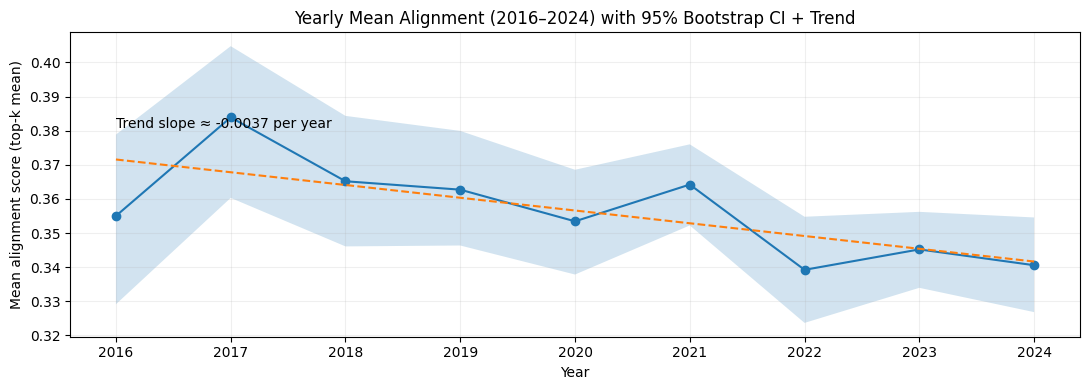

Saved: ./outputs_p7/report_findings_robust/figures/yearly_mean_ci95_trend_2016_2024.png
Saved: ./outputs_p7/report_findings_robust/tables/trend_summary_2016_2024.json


In [37]:
# ============================================================
# CELL B2 — 2016–2024 ONLY: yearly mean + bootstrap CI + trend line
# Purpose:
# - Report a drift visualization that is robust to 2025 low coverage
# - Provide a clean figure for the report
# ============================================================

def bootstrap_ci_mean(x, n_boot=2000, ci=0.95, seed=42):
    rng = np.random.default_rng(seed)
    x = np.asarray(x, dtype=float)
    boots = rng.choice(x, size=(n_boot, len(x)), replace=True).mean(axis=1)
    alpha = (1 - ci) / 2
    return float(np.quantile(boots, alpha)), float(np.quantile(boots, 1 - alpha))

# Filter to 2016–2024
df_1624 = df[(df["year_int"] >= 2016) & (df["year_int"] <= 2024)].copy()

# Aggregate + CI
rows = []
for y, g in df_1624.groupby("year_int"):
    vals = g[SCORE_COL].values
    lo, hi = bootstrap_ci_mean(vals, n_boot=2000, ci=0.95, seed=42 + int(y))
    rows.append({
        "year": int(y),
        "n": int(len(vals)),
        "mean": float(np.mean(vals)),
        "ci95_low": lo,
        "ci95_high": hi
    })

tbl = pd.DataFrame(rows).sort_values("year").reset_index(drop=True)
tbl_path = os.path.join(OUT_DIR, "tables", "yearly_mean_ci95_2016_2024.csv")
tbl.to_csv(tbl_path, index=False)
print("Saved:", tbl_path)
display(tbl)

# Linear trend on yearly means (2016–2024)
x = tbl["year"].values.astype(float)
y = tbl["mean"].values.astype(float)
b, a = np.polyfit(x, y, 1)  # y = b*x + a

# Plot
plt.figure(figsize=(11,4))
plt.plot(tbl["year"], tbl["mean"], marker="o")
plt.fill_between(tbl["year"], tbl["ci95_low"], tbl["ci95_high"], alpha=0.2)

# Trend line
y_hat = b * x + a
plt.plot(tbl["year"], y_hat, linestyle="--")

plt.title("Yearly Mean Alignment (2016–2024) with 95% Bootstrap CI + Trend")
plt.xlabel("Year")
plt.ylabel("Mean alignment score (top-k mean)")
plt.grid(True, alpha=0.2)

# Annotate slope
plt.text(tbl["year"].min(), tbl["mean"].max(),
         f"Trend slope ≈ {b:.4f} per year",
         va="top")

fig_path = os.path.join(OUT_DIR, "figures", "yearly_mean_ci95_trend_2016_2024.png")
plt.tight_layout()
plt.savefig(fig_path, dpi=160)
plt.show()
print("Saved:", fig_path)

# Save a small JSON snippet for the report
summary = {
    "subset": "2016-2024",
    "trend_slope_per_year": float(b),
    "trend_intercept": float(a),
    "note": "Trend computed on yearly means (reduces sensitivity to unequal n per year)."
}
json_path = os.path.join(OUT_DIR, "tables", "trend_summary_2016_2024.json")
with open(json_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=2)
print("Saved:", json_path)


In [42]:
# ============================================================
# CELL B3 — Outlier qualitative validation template (top 20)
# ============================================================

import os
import re
import numpy as np
import pandas as pd

# Load scope text (snapshot)
SCOPE_PATH = "reports/01_data_curation/machine_learning_aims_scope_snapshot.txt"

if os.path.exists(SCOPE_PATH):
    with open(SCOPE_PATH, "r", encoding="utf-8") as f:
        scope_text = f.read().strip()
else:
    scope_text = ""  # paste manually if needed

# Split scope into sentences
scope_sents = [s.strip() for s in re.split(r'(?<=[.!?])\s+', scope_text) if len(s.strip()) > 20]
print("Scope sentences:", len(scope_sents))

# Load embeddings
SCOPE_EMB_PATH = "./outputs_p7/scope_sentence_embeddings.npy"
ABS_EMB_PATH   = "./outputs_p7/abstract_embeddings.npy"

if not os.path.exists(SCOPE_EMB_PATH):
    raise FileNotFoundError(f"Missing {SCOPE_EMB_PATH}. Run the embedding cell that saves it.")
if not os.path.exists(ABS_EMB_PATH):
    raise FileNotFoundError(f"Missing {ABS_EMB_PATH}. Run the embedding cell that saves it.")

scope_emb = np.load(SCOPE_EMB_PATH)
abs_emb   = np.load(ABS_EMB_PATH)

# Cosine similarity helper
def cosine_sim_matrix(A, B):
    A = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-12)
    B = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-12)
    return A @ B.T

# Lowest 20 outliers
df_out = df.sort_values(SCORE_COL, ascending=True).head(20).copy()

# Map to embedding row indices (assumes embedding order == scored CSV order)
df_reset = df.reset_index().rename(columns={"index": "row_idx"})
df_out = df_out.merge(df_reset[["doi", "paperId", "row_idx"]], on=["doi", "paperId"], how="left")

if df_out["row_idx"].isna().any():
    print("WARNING: Some outliers couldn't be mapped to embedding rows. Check merge keys.")
df_out["row_idx"] = df_out["row_idx"].astype(int)

# Build qualitative validation table
out_rows = []
for _, r in df_out.iterrows():
    i = int(r["row_idx"])

    sims = cosine_sim_matrix(abs_emb[i:i+1], scope_emb)[0]   # (n_scope,)
    best_j = int(np.argmax(sims))

    abs_text = str(r.get("abstract", ""))
    abstract_excerpt = abs_text[:220] + "..." if len(abs_text) > 220 else abs_text

    out_rows.append({
        "year": int(r["year_int"]),
        "score": float(r[SCORE_COL]),
        "doi": r.get("doi", ""),
        "title": r.get("title", ""),
        "url": r.get("url", ""),
        "best_scope_sentence_idx": best_j,
        "best_scope_sentence_sim": float(sims[best_j]),
        "best_scope_sentence_text": scope_sents[best_j] if best_j < len(scope_sents) else "",
        "abstract_excerpt": abstract_excerpt
    })

out_tbl = pd.DataFrame(out_rows).sort_values("score").reset_index(drop=True)

out_path_csv = os.path.join(OUT_DIR, "tables", "outlier_qual_validation_top20.csv")
out_tbl.to_csv(out_path_csv, index=False)
print("Saved:", out_path_csv)

display(out_tbl.head(10))


Scope sentences: 0
Saved: ./outputs_p7/report_findings_robust/tables/outlier_qual_validation_top20.csv


,year,score,doi,title,url,best_scope_sentence_idx,best_scope_sentence_sim,best_scope_sentence_text,abstract_excerpt
0,2022,0.126197,10.1007/s10994-022-06235-3,3DVerifier: efficient robustness verification ...,https://www.semanticscholar.org/paper/86850f55...,10,0.142641,,3D point cloud models are widely applied in sa...
1,2022,0.162599,10.1007/s10994-022-06160-5,Heterogeneous graph embedding with single-leve...,https://www.semanticscholar.org/paper/30926e65...,10,0.184093,,There has been an increasing interest in devel...
2,2022,0.171384,10.1007/s10994-023-06435-5,Style spectroscope: improve interpretability a...,https://www.semanticscholar.org/paper/506c1308...,0,0.189075,,Universal style transfer (UST) infuses styles ...
3,2024,0.175687,10.1007/s10994-023-06499-3,When are they coming? Understanding and foreca...,https://www.semanticscholar.org/paper/8f5091aa...,0,0.181567,,Futbol Club Barcelona operates the largest sta...
4,2022,0.179925,10.1007/s10994-023-06508-5,Differentially private Riemannian optimization,https://www.semanticscholar.org/paper/ad5f16c8...,4,0.195437,,"In this paper, we study the differentially pri..."
5,2022,0.183160,10.1007/s10994-022-06252-2,DIMBA: discretely masked black-box attack in s...,https://www.semanticscholar.org/paper/38170bc2...,10,0.221046,,The adversarial attack can force a CNN-based m...
6,2024,0.183238,10.1007/s10994-024-06575-2,PROUD: PaRetO-gUided diffusion model for multi...,https://www.semanticscholar.org/paper/37afc980...,0,0.210562,,Recent advancements in the realm of deep gener...
7,2022,0.185434,10.1007/s10994-022-06258-w,Riemannian block SPD coupling manifold and its...,https://www.semanticscholar.org/paper/b7fd072f...,5,0.233673,,"In this work, we study the optimal transport (..."
8,2020,0.186300,10.1007/s10994-021-05970-3,"SPEED: secure, PrivatE, and efficient deep lea...",https://www.semanticscholar.org/paper/aa267677...,10,0.226624,,We introduce a deep learning framework able to...
9,2025,0.186651,10.1007/s10994-024-06648-2,Interactive sequential generative models for t...,https://www.semanticscholar.org/paper/1d7dedae...,0,0.197460,,Understanding spatiotemporal coordination of p...


In [50]:
# ============================================================
# CELL B1 (final) — Recompute best_scope_sentence_idx/sim + export outliers with scope text
# Why needed:
# - machine_learning_scored_2016_2025.csv does NOT contain best_scope_sentence_* columns yet
# - We compute them now using saved embeddings (fast, reproducible)
# ============================================================

import os
import re
import numpy as np
import pandas as pd

# ---- Paths ----
SCORED_PATH = "outputs_p7/machine_learning_scored_2016_2025.csv"

SCOPE_EMB_PATH = "outputs_p7/scope_sentence_embeddings.npy"
ABSTRACT_EMB_PATH = "outputs_p7/abstract_embeddings.npy"

OUT_DIR = "outputs_p7/report_findings/tables"
OUT_CSV = os.path.join(OUT_DIR, "outliers_lowest_20_with_scope_sentence.csv")
OUT_MD  = os.path.join(OUT_DIR, "outliers_lowest_20_with_scope_sentence.md")

SCOPE_FILENAME = "machine_learning_aims_scope_snapshot.txt"

# ---- Helper: find file anywhere ----
def find_file(root_dir: str, filename: str):
    for root, _, files in os.walk(root_dir):
        if filename in files:
            return os.path.join(root, filename)
    return None

# ---- Load scope text ----
scope_path = find_file(".", SCOPE_FILENAME)
if scope_path is None:
    raise FileNotFoundError(f"Could not find {SCOPE_FILENAME} anywhere.")

with open(scope_path, "r", encoding="utf-8") as f:
    scope_text = f.read().strip()

scope_sentences = [s.strip() for s in re.split(r'(?<=[.!?])\s+', scope_text) if s.strip()]

print("✅ Found scope snapshot at:", scope_path)
print("Loaded scope sentences:", len(scope_sentences))

# ---- Load scored df ----
df_sc = pd.read_csv(SCORED_PATH)
print("Loaded scored df:", df_sc.shape)

# ---- Load embeddings ----
if not (os.path.exists(SCOPE_EMB_PATH) and os.path.exists(ABSTRACT_EMB_PATH)):
    raise FileNotFoundError(
        "Missing embedding .npy files.\n"
        f"Expected:\n - {SCOPE_EMB_PATH}\n - {ABSTRACT_EMB_PATH}\n"
        "If they don't exist, you need to rerun the embedding cell that saves them."
    )

scope_emb = np.load(SCOPE_EMB_PATH)         # (S, 768)
abs_emb   = np.load(ABSTRACT_EMB_PATH)      # (N, 768)

print("Scope emb shape:", scope_emb.shape)
print("Abstract emb shape:", abs_emb.shape)

# ---- Safety: embeddings must match df row order/length ----
if abs_emb.shape[0] != len(df_sc):
    raise ValueError(
        f"Row mismatch: abstract_embeddings has {abs_emb.shape[0]} rows, "
        f"but df_sc has {len(df_sc)} rows.\n"
        "This usually happens if df_sc was filtered/reordered after embeddings were saved."
    )

# ---- Cosine similarity matrix (N x S), done efficiently ----
# Normalize
scope_norm = scope_emb / (np.linalg.norm(scope_emb, axis=1, keepdims=True) + 1e-12)
abs_norm   = abs_emb   / (np.linalg.norm(abs_emb,   axis=1, keepdims=True) + 1e-12)

# sims[i, j] = cosine(abstract_i, scope_sentence_j)
sims = abs_norm @ scope_norm.T  # (N, S)

best_idx = sims.argmax(axis=1)                           # (N,)
best_sim = sims[np.arange(sims.shape[0]), best_idx]      # (N,)

df_sc["best_scope_sentence_idx"] = best_idx.astype(int)
df_sc["best_scope_sentence_sim"] = best_sim.astype(float)

# Map idx -> actual sentence text
def idx_to_sentence(i: int) -> str:
    if 0 <= i < len(scope_sentences):
        return scope_sentences[i]
    return f"[IDX_OUT_OF_RANGE: {i} / {len(scope_sentences)}]"

df_sc["best_scope_sentence_text"] = df_sc["best_scope_sentence_idx"].apply(idx_to_sentence)

# ---- Build outliers ----
outliers = (
    df_sc.sort_values("alignment_score_topk_mean", ascending=True)
         .head(20)
         .copy()
)

# Create excerpt if not present
outliers["abstract_excerpt"] = (
    outliers["abstract"].fillna("")
    .str.replace(r"\s+", " ", regex=True)
    .str.slice(0, 220)
    + "..."
)

# ---- Export ----
cols_order = [
    "year_final",
    "alignment_score_topk_mean",
    "doi",
    "title",
    "url",
    "best_scope_sentence_idx",
    "best_scope_sentence_sim",
    "best_scope_sentence_text",
    "abstract_excerpt",
]

outliers_export = outliers[cols_order].rename(columns={
    "year_final": "year",
    "alignment_score_topk_mean": "score"
})

os.makedirs(OUT_DIR, exist_ok=True)
outliers_export.to_csv(OUT_CSV, index=False)

with open(OUT_MD, "w", encoding="utf-8") as f:
    f.write(outliers_export.to_markdown(index=False))

print("✅ Saved fixed outlier sheet:")
print(" -", OUT_CSV)
print(" -", OUT_MD)

display(outliers_export.head(5))


✅ Found scope snapshot at: ./machine_learning_aims_scope_snapshot.txt
Loaded scope sentences: 12
Loaded scored df: (754, 20)
Scope emb shape: (12, 768)
Abstract emb shape: (754, 768)
✅ Saved fixed outlier sheet:
 - outputs_p7/report_findings/tables/outliers_lowest_20_with_scope_sentence.csv
 - outputs_p7/report_findings/tables/outliers_lowest_20_with_scope_sentence.md


,year,score,doi,title,url,best_scope_sentence_idx,best_scope_sentence_sim,best_scope_sentence_text,abstract_excerpt
623,2022.0,0.126197,10.1007/s10994-022-06235-3,3DVerifier: efficient robustness verification ...,https://www.semanticscholar.org/paper/86850f55...,10,0.142641,All papers must place their contribution clear...,3D point cloud models are widely applied in sa...
279,2022.0,0.162599,10.1007/s10994-022-06160-5,Heterogeneous graph embedding with single-leve...,https://www.semanticscholar.org/paper/30926e65...,10,0.184093,All papers must place their contribution clear...,There has been an increasing interest in devel...
530,2022.0,0.171384,10.1007/s10994-023-06435-5,Style spectroscope: improve interpretability a...,https://www.semanticscholar.org/paper/506c1308...,0,0.189074,Aims and scope Machine Learning is an internat...,Universal style transfer (UST) infuses styles ...
167,2024.0,0.175687,10.1007/s10994-023-06499-3,When are they coming? Understanding and foreca...,https://www.semanticscholar.org/paper/8f5091aa...,0,0.181567,Aims and scope Machine Learning is an internat...,Futbol Club Barcelona operates the largest sta...
365,2022.0,0.179925,10.1007/s10994-023-06508-5,Differentially private Riemannian optimization,https://www.semanticscholar.org/paper/ad5f16c8...,4,0.195437,Papers making claims about learning problems (...,"In this paper, we study the differentially pri..."


In [51]:
# ============================================================
# CELL C0 — Setup for "Negative set" + Contrast scoring
# Goal:
# - Keep existing scored dataset untouched
# - Add new columns:
#   (1) sim_neg_centroid
#   (2) contrast_score = sim_scope_topk_mean - sim_neg_centroid
# - Re-run drift/outlier analysis on contrast_score in a separate folder
# ============================================================

import os
import re
import json
import time
import math
import numpy as np
import pandas as pd

from typing import List, Dict, Tuple

# ---- Input files (already produced by your pipeline) ----
SCORED_PATH = "outputs_p7/machine_learning_scored_2016_2025.csv"
ABSTRACT_EMB_PATH = "outputs_p7/abstract_embeddings.npy"
SCOPE_SENT_EMB_PATH = "outputs_p7/scope_sentence_embeddings.npy"
SCOPE_SNAPSHOT_TXT = "machine_learning_aims_scope_snapshot.txt"  # found earlier in your workspace

# ---- Output dirs ----
NEG_DIR = "outputs_p7/negatives"
OUT_DIR = "outputs_p7/contrast"
REPORT_DIR = os.path.join(OUT_DIR, "report_findings")

os.makedirs(NEG_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(REPORT_DIR, exist_ok=True)

# ---- Year range ----
START_YEAR = 2016
END_YEAR = 2025

print("✅ Setup done.")
print("SCORED_PATH:", SCORED_PATH)
print("OUT_DIR:", OUT_DIR)


✅ Setup done.
SCORED_PATH: outputs_p7/machine_learning_scored_2016_2025.csv
OUT_DIR: outputs_p7/contrast


In [52]:
# ============================================================
# CELL C1 — Load scored dataset + embeddings + verify shapes
# ============================================================

# ---- Load scored dataset ----
df_sc = pd.read_csv(SCORED_PATH)
print("Loaded scored dataset:", df_sc.shape)
print("Columns:", df_sc.columns.tolist())

# Ensure year_int exists (for later drift tests)
if "year_int" not in df_sc.columns:
    df_sc["year_int"] = pd.to_numeric(df_sc["year_final"], errors="coerce").astype(int)

# ---- Load embeddings (saved earlier) ----
abs_emb = np.load(ABSTRACT_EMB_PATH)               # shape: (754, 768)
scope_sent_emb = np.load(SCOPE_SENT_EMB_PATH)      # shape: (n_sent, 768)

print("Abstract embeddings shape:", abs_emb.shape)
print("Scope sentence embeddings shape:", scope_sent_emb.shape)

assert abs_emb.shape[0] == len(df_sc), "Mismatch: df rows vs abstract embeddings rows"

# ---- Normalize for cosine similarity (VERY important) ----
def l2_normalize(x: np.ndarray, axis: int = 1, eps: float = 1e-12) -> np.ndarray:
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / np.clip(norm, eps, None)

abs_emb_n = l2_normalize(abs_emb, axis=1)
scope_sent_emb_n = l2_normalize(scope_sent_emb, axis=1)

# ---- Compute scope similarity per paper: top-k mean across scope sentences ----
TOPK = 3

# sims shape: (n_sentences, n_papers)
sims = scope_sent_emb_n @ abs_emb_n.T

# best sentence idx + best sim (max)
best_idx = np.argmax(sims, axis=0)
best_sim = np.max(sims, axis=0)

# top-k mean sim
# sort descending along sentence dimension
sims_sorted = np.sort(sims, axis=0)[::-1, :]
topk_mean = sims_sorted[:TOPK, :].mean(axis=0)

df_sc["sim_scope_best"] = best_sim.astype(float)
df_sc["best_scope_sentence_idx"] = best_idx.astype(int)
df_sc["sim_scope_topk_mean_recomputed"] = topk_mean.astype(float)

# ---- Sanity: compare with existing alignment_score_topk_mean if exists ----
if "alignment_score_topk_mean" in df_sc.columns:
    diff = np.abs(df_sc["alignment_score_topk_mean"].values - df_sc["sim_scope_topk_mean_recomputed"].values)
    print("Sanity check |alignment_score_topk_mean - recomputed|:")
    print(" - mean abs diff:", float(diff.mean()))
    print(" - max  abs diff:", float(diff.max()))
else:
    print("⚠️ alignment_score_topk_mean not found. We'll use recomputed scope score as main scope score.")

print("✅ Scope similarity columns added.")
df_sc[["year_int", "sim_scope_best", "sim_scope_topk_mean_recomputed"]].head()


Loaded scored dataset: (754, 20)
Columns: ['doi', 'paperId', 'title', 'abstract', 'year', 'venue_name', 'publicationTypes', 'authors', 'url', '_status', 'doi_norm', 'container_title_crossref', 'year_crossref', 'type_crossref', 'title_crossref', 'year_s2', 'year_cr', 'year_final', 'alignment_score_max', 'alignment_score_topk_mean']
Abstract embeddings shape: (754, 768)
Scope sentence embeddings shape: (12, 768)
Sanity check |alignment_score_topk_mean - recomputed|:
 - mean abs diff: 1.2696222158521097e-08
 - max  abs diff: 9.826660157807865e-08
✅ Scope similarity columns added.


,year_int,sim_scope_best,sim_scope_topk_mean_recomputed
0,2016,0.452986,0.410006
1,2020,0.464099,0.405617
2,2020,0.418456,0.383527
3,2022,0.232446,0.226388
4,2023,0.445824,0.403852


In [53]:
# ============================================================
# CELL C2 — Build negative set via Semantic Scholar search API
# Strategy:
# - For each year, collect ~same number as retained ML papers (capped)
# - Use non-ML queries: database, cryptography, networks, operating systems
# - Keep only papers with non-empty abstracts
# - Save checkpoint CSV so you NEVER need to refetch unless you want
# ============================================================

import requests

NEG_RAW_CSV = os.path.join(NEG_DIR, f"negatives_raw_{START_YEAR}_{END_YEAR}.csv")
NEG_CUR_CSV = os.path.join(NEG_DIR, f"negatives_curated_{START_YEAR}_{END_YEAR}.csv")

# If checkpoint exists, load and skip API calls
if os.path.exists(NEG_CUR_CSV):
    neg_df = pd.read_csv(NEG_CUR_CSV)
    print("✅ Loaded NEGATIVE set from checkpoint:", neg_df.shape)
else:
    S2_API_KEY = os.getenv("S2_API_KEY", "")  # optional
    headers = {"User-Agent": "P7-Alignment-Project/1.0"}
    if S2_API_KEY:
        headers["x-api-key"] = S2_API_KEY

    BASE_URL = "https://api.semanticscholar.org/graph/v1/paper/search"

    NEG_QUERIES = [
        "database systems query optimization transaction processing",
        "cryptography authentication protocol security",
        "computer networks routing congestion control",
        "operating systems scheduling memory management",
        "distributed systems consensus replication"
    ]

    # How many negatives per year?
    # - match your retained ML paper counts per year, but cap for speed
    year_counts = df_sc.groupby("year_int").size().to_dict()
    print("ML retained counts by year (reference):", year_counts)

    def fetch_one_year(query: str, year: int, limit_total: int = 60) -> List[Dict]:
        """
        Fetch up to limit_total papers for a single (query, year) using pagination.
        We request abstracts and basic metadata.
        """
        fields = "title,abstract,year,venue,externalIds,url"
        out = []
        offset = 0
        page_size = 100  # max is typically 100

        while len(out) < limit_total:
            params = {
                "query": query,
                "limit": min(page_size, limit_total - len(out)),
                "offset": offset,
                "fields": fields,
                "year": str(year)  # semantic scholar supports a year param in many cases
            }

            r = requests.get(BASE_URL, headers=headers, params=params, timeout=60)
            if r.status_code != 200:
                print("⚠️ API error:", r.status_code, r.text[:200])
                break

            data = r.json()
            batch = data.get("data", [])
            if not batch:
                break

            out.extend(batch)
            offset += len(batch)

            # Gentle rate-limiting
            time.sleep(0.5)

        return out[:limit_total]

    neg_rows = []

    for y in range(START_YEAR, END_YEAR + 1):
        target_n = int(min(max(year_counts.get(y, 50), 20), 80))  # min 20, max 80 per year
        per_query_n = math.ceil(target_n / len(NEG_QUERIES))

        print(f"\nYear {y}: target negatives ~{target_n} (per_query ~{per_query_n})")

        year_items = []
        for q in NEG_QUERIES:
            items = fetch_one_year(q, y, limit_total=per_query_n)
            year_items.extend(items)

        # Flatten + minimal normalize
        for it in year_items:
            ext = it.get("externalIds", {}) or {}
            doi = ext.get("DOI", None)
            neg_rows.append({
                "year": it.get("year", None),
                "title": it.get("title", ""),
                "abstract": it.get("abstract", ""),
                "venue": it.get("venue", ""),
                "doi": doi,
                "url": it.get("url", "")
            })

    neg_df_raw = pd.DataFrame(neg_rows)
    neg_df_raw.to_csv(NEG_RAW_CSV, index=False)
    print("\n✅ Saved negative RAW checkpoint:", NEG_RAW_CSV, neg_df_raw.shape)

    # ---- Curate negatives: keep non-empty abstracts, correct years, dedup ----
    neg_df = neg_df_raw.copy()
    neg_df["year"] = pd.to_numeric(neg_df["year"], errors="coerce")
    neg_df = neg_df[(neg_df["year"] >= START_YEAR) & (neg_df["year"] <= END_YEAR)].copy()

    neg_df["abstract"] = neg_df["abstract"].fillna("").astype(str)
    neg_df["abs_len"] = neg_df["abstract"].str.len()
    neg_df = neg_df[neg_df["abs_len"] >= 10].copy()

    # Remove any accidental overlap with Machine Learning journal DOIs (extra safety)
    if "doi_norm" in df_sc.columns:
        ml_dois = set(df_sc["doi_norm"].dropna().astype(str).tolist())
        neg_df["doi_norm"] = neg_df["doi"].fillna("").astype(str).str.lower().str.strip()
        neg_df = neg_df[~neg_df["doi_norm"].isin(ml_dois)].copy()

    # Deduplicate by (title + year) because DOI might be missing
    neg_df["title_norm"] = neg_df["title"].fillna("").astype(str).str.lower().str.strip()
    neg_df = neg_df.drop_duplicates(subset=["year", "title_norm"]).copy()

    neg_df.drop(columns=["abs_len"], errors="ignore").to_csv(NEG_CUR_CSV, index=False)
    print("✅ Saved negative CURATED checkpoint:", NEG_CUR_CSV, neg_df.shape)

neg_df.head()


ML retained counts by year (reference): {2016: 25, 2017: 31, 2018: 46, 2019: 60, 2020: 102, 2021: 121, 2022: 114, 2023: 110, 2024: 98, 2025: 47}

Year 2016: target negatives ~25 (per_query ~5)
⚠️ API error: 429 {"message": "Too Many Requests. Please wait and try again or apply for a key for higher rate limits. https://www.semanticscholar.org/product/api#api-key-form", "code": "429"}
⚠️ API error: 429 {"message": "Too Many Requests. Please wait and try again or apply for a key for higher rate limits. https://www.semanticscholar.org/product/api#api-key-form", "code": "429"}
⚠️ API error: 429 {"message": "Too Many Requests. Please wait and try again or apply for a key for higher rate limits. https://www.semanticscholar.org/product/api#api-key-form", "code": "429"}

Year 2017: target negatives ~31 (per_query ~7)
⚠️ API error: 429 {"message": "Too Many Requests. Please wait and try again or apply for a key for higher rate limits. https://www.semanticscholar.org/product/api#api-key-form", "c

,year,title,abstract,venue,doi,url,abs_len,doi_norm,title_norm
1,2016,A Secure Anonymous Authentication Protocol for...,Mobile user authentication is an essential top...,IEEE Access,10.1109/ACCESS.2016.2596292,https://www.semanticscholar.org/paper/0d5267a2...,1347,10.1109/access.2016.2596292,a secure anonymous authentication protocol for...
2,2016,On the Security of the Algebraic Eraser Tag Au...,The Algebraic Eraser has been gaining prominen...,International Conference on Applied Cryptograp...,10.1007/978-3-319-39555-5_1,https://www.semanticscholar.org/paper/95cbf366...,902,10.1007/978-3-319-39555-5_1,on the security of the algebraic eraser tag au...
4,2016,An Efficient QR-code Authentication Protocol u...,"Background: Now a day, data communication play...",,10.17485/IJST/2016/V9I39/102071,https://www.semanticscholar.org/paper/0bfd11ba...,1224,10.17485/ijst/2016/v9i39/102071,an efficient qr-code authentication protocol u...
5,2016,Congestion Control Using Fuzzy Based LSPS in M...,"In this paper, we have proposed a fuzzy based ...",IEEE Annual Symposium on Foundations of Comput...,10.5121/IJFCST.2016.6201,https://www.semanticscholar.org/paper/a0de72ce...,1264,10.5121/ijfcst.2016.6201,congestion control using fuzzy based lsps in m...
7,2016,Ant-Net: An adaptive routing algorithm,With the increasing demand and complexity of n...,IEEE International Conference on Power Electro...,10.1109/ICPEICES.2016.7853616,https://www.semanticscholar.org/paper/a055b91d...,1182,10.1109/icpeices.2016.7853616,ant-net: an adaptive routing algorithm


In [54]:
# ============================================================
# CELL C3 — Embed negative abstracts and compute negative centroid
# Notes:
# - Uses same embedding model you already used: all-mpnet-base-v2
# - Saves neg_embeddings.npy as a checkpoint
# ============================================================

NEG_EMB_PATH = os.path.join(NEG_DIR, f"neg_abstract_embeddings_{START_YEAR}_{END_YEAR}.npy")

if os.path.exists(NEG_EMB_PATH):
    neg_emb = np.load(NEG_EMB_PATH)
    print("✅ Loaded negative embeddings from checkpoint:", neg_emb.shape)
else:
    from sentence_transformers import SentenceTransformer

    model_name = "sentence-transformers/all-mpnet-base-v2"
    model = SentenceTransformer(model_name)
    print("✅ Loaded embedding model:", model_name)

    texts = neg_df["abstract"].fillna("").astype(str).tolist()

    # Batched encoding (safer)
    batch_size = 64
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        e = model.encode(batch, show_progress_bar=False, convert_to_numpy=True)
        embs.append(e)

    neg_emb = np.vstack(embs)
    np.save(NEG_EMB_PATH, neg_emb)
    print("✅ Saved negative embeddings checkpoint:", NEG_EMB_PATH, neg_emb.shape)

# Normalize + compute centroid
neg_emb_n = l2_normalize(neg_emb, axis=1)
neg_centroid = neg_emb_n.mean(axis=0, keepdims=True)
neg_centroid = l2_normalize(neg_centroid, axis=1)[0]

print("Negative centroid shape:", neg_centroid.shape)


✅ Loaded embedding model: sentence-transformers/all-mpnet-base-v2
✅ Saved negative embeddings checkpoint: outputs_p7/negatives/neg_abstract_embeddings_2016_2025.npy (174, 768)
Negative centroid shape: (768,)


In [56]:
# ============================================================
# CELL C4 (print upgrade) — Pretty tables for outputs
# ============================================================

import pandas as pd
import numpy as np
import json
import os

# ---- 1) Quick stats table (already nice) ----
quick_stats = df_sc[["sim_scope_topk_mean", "sim_neg_centroid", "contrast_score"]].describe().T
quick_stats = quick_stats.rename(columns={
    "count": "n",
    "mean": "mean",
    "std": "std",
    "min": "min",
    "25%": "p25",
    "50%": "median",
    "75%": "p75",
    "max": "max"
}).reset_index().rename(columns={"index": "metric"})

print("✅ Saved contrast-scored dataset:", OUT_SCORED_CONTRAST)
print("\n=== Quick stats (table) ===")
display(quick_stats)

# ---- 2) Drift test summary table (ALL vs 2016–2024) ----
drift_table = pd.DataFrame([
    {
        "subset": "ALL (2016–2025)",
        "years_included": f"{years_all[0]}–{years_all[-1]}",
        "kruskal_stat": stat_all,
        "kruskal_p": p_all,
        "trend_slope_b_per_year": b_all,
        "trend_intercept_a": a_all
    },
    {
        "subset": "2016–2024 only",
        "years_included": f"{years_1624[0]}–{years_1624[-1]}",
        "kruskal_stat": stat_1624,
        "kruskal_p": p_1624,
        "trend_slope_b_per_year": b_1624,
        "trend_intercept_a": a_1624
    }
])

# Optional: nicer rounding for display
drift_table_display = drift_table.copy()
drift_table_display["kruskal_stat"] = drift_table_display["kruskal_stat"].round(3)
drift_table_display["kruskal_p"] = drift_table_display["kruskal_p"].apply(lambda x: f"{x:.4f}")
drift_table_display["trend_slope_b_per_year"] = drift_table_display["trend_slope_b_per_year"].round(6)
drift_table_display["trend_intercept_a"] = drift_table_display["trend_intercept_a"].round(3)

print("\n=== Drift tests (contrast_score) — summary table ===")
display(drift_table_display)

# ---- 3) Still save JSON (grader-friendly artifact) ----
drift_results = {
    "contrast_all_years": {
        "kruskal_stat": float(stat_all),
        "kruskal_p": float(p_all),
        "trend_slope_b_per_year": float(b_all),
        "trend_intercept_a": float(a_all),
        "years": [int(y) for y in years_all]
    },
    "contrast_2016_2024": {
        "kruskal_stat": float(stat_1624),
        "kruskal_p": float(p_1624),
        "trend_slope_b_per_year": float(b_1624),
        "trend_intercept_a": float(a_1624),
        "years": [int(y) for y in years_1624]
    }
}

DRIFT_JSON = os.path.join(REPORT_DIR, "drift_tests_contrast_all_vs_2016_2024.json")
with open(DRIFT_JSON, "w", encoding="utf-8") as f:
    json.dump(drift_results, f, indent=2)

print("\n✅ Drift JSON saved:", DRIFT_JSON)

# ---- 4) Optional: export drift table as CSV + Markdown for report ----
DRIFT_CSV = os.path.join(REPORT_DIR, "drift_tests_contrast_all_vs_2016_2024_table.csv")
DRIFT_MD  = os.path.join(REPORT_DIR, "drift_tests_contrast_all_vs_2016_2024_table.md")

drift_table.to_csv(DRIFT_CSV, index=False)
with open(DRIFT_MD, "w", encoding="utf-8") as f:
    f.write(drift_table_display.to_markdown(index=False))

print("✅ Drift table saved:")
print(" -", DRIFT_CSV)
print(" -", DRIFT_MD)


✅ Saved contrast-scored dataset: outputs_p7/contrast/machine_learning_scored_contrast_2016_2025.csv

=== Quick stats (table) ===


,metric,n,mean,std,min,p25,median,p75,max
0,sim_scope_topk_mean,754.0,0.351379,0.071186,0.126197,0.305338,0.350573,0.402525,0.627483
1,sim_neg_centroid,754.0,0.148485,0.071739,-0.083530,0.102200,0.146280,0.193511,0.476682
2,contrast_score,754.0,0.202895,0.092561,-0.145027,0.150464,0.209019,0.268201,0.444567



=== Drift tests (contrast_score) — summary table ===


,subset,years_included,kruskal_stat,kruskal_p,trend_slope_b_per_year,trend_intercept_a
0,ALL (2016–2025),2016–2025,7.080,0.6288,-0.003075,6.419
1,2016–2024 only,2016–2024,6.714,0.5678,-0.003276,6.825



✅ Drift JSON saved: outputs_p7/contrast/report_findings/drift_tests_contrast_all_vs_2016_2024.json
✅ Drift table saved:
 - outputs_p7/contrast/report_findings/drift_tests_contrast_all_vs_2016_2024_table.csv
 - outputs_p7/contrast/report_findings/drift_tests_contrast_all_vs_2016_2024_table.md


In [81]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [82]:
!find /content/drive/MyDrive -name "*.ipynb" -print


/content/drive/MyDrive/Colab Notebooks/Untitled1.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled2.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled3.ipynb
/content/drive/MyDrive/Colab Notebooks/MNIST (1).ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled0.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled4.ipynb
/content/drive/MyDrive/Colab Notebooks/MNIST.ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled5.ipynb
/content/drive/MyDrive/Colab Notebooks/uzunsüren.ipynb
/content/drive/MyDrive/Colab Notebooks/yineuzun.ipynb
/content/drive/MyDrive/Colab Notebooks/çizimlibaşlayamadı.ipynb
/content/drive/MyDrive/Colab Notebooks/Mnıst.ipynb
/content/drive/MyDrive/Colab Notebooks/LEVERAGING QNNs AND TWO-WAY QUANTUM COMPUTING FOR INTERCEPTOR MECHANICS AT MERCURY L2 (2).ipynb
/content/drive/MyDrive/Colab Notebooks/LEVERAGING QNNs AND TWO-WAY QUANTUM COMPUTING FOR INTERCEPTOR MECHANICS AT MERCURY L2 (1).ipynb
/content/drive/MyDrive/Colab Notebooks/Untitled7.ipynb
/content/dri